# One-to-Many Face Recognition Authentication System

This notebook implements a comprehensive face recognition authentication system using DeepFace library with:
- **Primary Model**: GhostFaceNet
- **Fallback Model**: FaceNet
- **Database**: JSON-based storage
- **Pipeline**: Face detection → Alignment → Augmentation → Embedding → Recognition

## Features:
1. Configurable models and face alignment algorithms
2. Image augmentation with lighting variations
3. Embedding storage in JSON database
4. Top-5 similarity matching with distance scores
5. Comprehensive logging and evaluation metrics

In [1]:
# Import required libraries
import os
import json
import numpy as np
import cv2
from pathlib import Path
from datetime import datetime
import logging
from typing import Dict, List, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

# DeepFace imports
from deepface import DeepFace
from deepface.modules import detection, representation, modeling

# Data science libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully!")
print(f"DeepFace version: {DeepFace.__version__ if hasattr(DeepFace, '__version__') else 'Not available'}")

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


Libraries imported successfully!
DeepFace version: 0.0.93


In [2]:
# Configuration class for easy model and algorithm changes
class FaceRecognitionConfig:
    def __init__(self):
        # Scalable model configurations - now supports multiple fallback models
        self.primary_model = "Facenet"
        self.fallback_models = ["ArcFace","GhostFaceNet"]  # List of fallback models in priority order
        
        # Face detection backends (easily changeable)
        self.primary_detector = "mtcnn"  # Options: opencv, ssd, dlib, mtcnn, retinaface, mediapipe
        self.fallback_detectors = ["mtcnn","mtcnn"]  # Corresponding detectors for fallback models
        
        # Face alignment algorithms
        self.alignment_algorithm = True  # Enable face alignment
        
        # Distance metrics
        self.distance_metric = "cosine"  # Options: cosine, euclidean, euclidean_l2
        
        # Model-specific similarity thresholds
        self.model_thresholds = {
            "GhostFaceNet": 0.68, #original: 0.65
            "Facenet": 0.65, #original: 40
            "Facenet512": 0.30, # Facenet with 512 dimensions
            "ArcFace": 0.68,
            "VGG-Face": 0.68,
            "OpenFace": 0.10,
            "DeepFace": 0.23,
            "DeepID": 0.015,
            "Dlib": 0.07,
            "SFace": 0.593
        }
        
        # Image preprocessing configurations
        self.resize_config = {
            "enabled": True,           # Set to False to skip resizing
            "target_size": (224, 224), # Target dimensions (width, height)
            "maintain_aspect_ratio": True,  # Whether to maintain aspect ratio
            "interpolation": cv2.INTER_LINEAR  # Interpolation method
        }
        
        # Enhanced augmentation parameters
        self.lighting_variations = [0.6, 0.8, 1.2, 1.4]  # Brightness multipliers
        self.sphere_positions = ["left", "right", "top", "bottom"]  # White sphere lighting positions
        self.sphere_intensity_variations = [0.3, 0.5, 0.7, 0.9]  # Different sphere intensity levels
        self.enable_augmentation = True
        
        # Legacy threshold for backward compatibility
        self.similarity_threshold = 0.68  # Default threshold if model-specific not found
        self.top_k_matches = 5
        
        # Enhanced fallback mechanism parameters
        self.ambiguity_distance_threshold = 0.1  # If next best match is within this distance, use fallback
        self.max_recognized_threshold = 1  # If more than this many matches are recognized, use fallback
        self.enable_enhanced_fallback = True # Enable fallback mechanism
        
        # Paths
        self.database_path = "face_database"
        self.query_path = "sample_images"
        self.json_db_file = "face_embeddings_db.json"
        self.results_file = "recognition_results.json"
        
        # Logging
        self.log_level = logging.INFO
    
    def get_threshold_for_model(self, model_name: str) -> float:
        """Get the specific threshold for a model, or default if not found"""
        return self.model_thresholds.get(model_name, self.similarity_threshold)
    
    def get_all_models(self) -> List[str]:
        """Get all models (primary + fallbacks) in priority order"""
        return [self.primary_model] + self.fallback_models
    
    def get_detector_for_model(self, model_name: str) -> str:
        """Get the corresponding detector for a model"""
        all_models = self.get_all_models()
        all_detectors = [self.primary_detector] + self.fallback_detectors
        
        try:
            index = all_models.index(model_name)
            return all_detectors[index] if index < len(all_detectors) else self.primary_detector
        except (ValueError, IndexError):
            return self.primary_detector

# Initialize configuration
config = FaceRecognitionConfig()

print("Enhanced Configuration initialized:")
print(f"Primary Model: {config.primary_model}")
print(f"Fallback Models: {config.fallback_models}")
print(f"Primary Detector: {config.primary_detector}")
print(f"Fallback Detectors: {config.fallback_detectors}")
print(f"Distance Metric: {config.distance_metric}")
print(f"Image Resize Enabled: {config.resize_config['enabled']}")
print(f"Target Size: {config.resize_config['target_size']}")
print(f"Augmentation Enabled: {config.enable_augmentation}")
print(f"Sphere Positions: {config.sphere_positions}")
print(f"Enhanced Fallback: {config.enable_enhanced_fallback}")
print(f"Model-specific Thresholds: {list(config.model_thresholds.items())[:3]}...")
print(f"Top K Matches: {config.top_k_matches}")
print(f"Database Path: {config.database_path}")
print(f"Query Path: {config.query_path}")

Enhanced Configuration initialized:
Primary Model: Facenet
Fallback Models: ['ArcFace', 'GhostFaceNet']
Primary Detector: mtcnn
Fallback Detectors: ['mtcnn', 'mtcnn']
Distance Metric: cosine
Image Resize Enabled: True
Target Size: (224, 224)
Augmentation Enabled: True
Sphere Positions: ['left', 'right', 'top', 'bottom']
Enhanced Fallback: True
Model-specific Thresholds: [('GhostFaceNet', 0.68), ('Facenet', 0.65), ('Facenet512', 0.3)]...
Top K Matches: 5
Database Path: face_database
Query Path: sample_images


In [3]:
# Utility functions for face processing
class FaceProcessor:
    def __init__(self, config: FaceRecognitionConfig):
        self.config = config
        self.logger = logging.getLogger(__name__)
    
    def resize_image(self, image: np.ndarray) -> np.ndarray:
        """Resize image according to configuration"""
        if not self.config.resize_config["enabled"]:
            return image
        
        target_size = self.config.resize_config["target_size"]
        maintain_aspect = self.config.resize_config["maintain_aspect_ratio"]
        interpolation = self.config.resize_config["interpolation"]
        
        h, w = image.shape[:2]
        target_w, target_h = target_size
        
        if maintain_aspect:
            # Calculate scaling factor to maintain aspect ratio
            scale = min(target_w / w, target_h / h)
            new_w = int(w * scale)
            new_h = int(h * scale)
            
            # Resize image
            resized = cv2.resize(image, (new_w, new_h), interpolation=interpolation)
            
            # Pad to target size if needed
            if new_w != target_w or new_h != target_h:
                # Create canvas with target size
                canvas = np.zeros((target_h, target_w, 3), dtype=image.dtype)
                
                # Center the resized image
                start_y = (target_h - new_h) // 2
                start_x = (target_w - new_w) // 2
                canvas[start_y:start_y + new_h, start_x:start_x + new_w] = resized
                
                return canvas
            else:
                return resized
        else:
            # Direct resize without maintaining aspect ratio
            return cv2.resize(image, target_size, interpolation=interpolation)
    
    def adjust_lighting(self, image: np.ndarray, brightness_factor: float) -> np.ndarray:
        """Apply lighting variation to image"""
        adjusted = cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)
        return adjusted
    
    def apply_sphere_lighting(self, image: np.ndarray, position: str, intensity: float = 0.3) -> np.ndarray:
        """Apply white sphere lighting effect to simulate various lighting angles"""
        height, width = image.shape[:2]
        
        # Create a white sphere mask based on position
        mask = np.zeros((height, width), dtype=np.float32)
        
        # Define sphere center based on position
        if position == "left":
            center_x, center_y = int(width * 0.2), int(height * 0.5)
        elif position == "right":
            center_x, center_y = int(width * 0.8), int(height * 0.5)
        elif position == "top":
            center_x, center_y = int(width * 0.5), int(height * 0.2)
        elif position == "bottom":
            center_x, center_y = int(width * 0.5), int(height * 0.8)
        else:
            center_x, center_y = int(width * 0.5), int(height * 0.5)
        
        # Create gradient sphere effect
        radius = min(width, height) * 0.4
        y, x = np.ogrid[:height, :width]
        distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        
        # Create smooth falloff
        sphere_mask = np.clip(1 - distance / radius, 0, 1)
        sphere_mask = sphere_mask ** 2  # Smooth falloff
        
        # Apply the lighting effect
        result = image.astype(np.float32)
        lighting_effect = sphere_mask[..., np.newaxis] * intensity * 255
        
        result = result + lighting_effect
        result = np.clip(result, 0, 255).astype(np.uint8)
        
        return result
    
    def generate_augmented_images(self, image_path: str) -> List[Tuple[np.ndarray, str]]:
        """Generate augmented versions of the image with different lighting and sphere positions"""
        try:
            # Read original image
            original_img = cv2.imread(image_path)
            if original_img is None:
                self.logger.error(f"Failed to load image: {image_path}")
                return []
            
            # Resize image if configured
            original_img = self.resize_image(original_img)
            
            augmented_images = [(original_img, "original")]
            
            if self.config.enable_augmentation:          
                # Add brightness variations
                for brightness in self.config.lighting_variations:  
                    brightness_img = self.adjust_lighting(original_img, brightness)
                    augmented_images.append((brightness_img, f"brightness_{brightness}"))      
                # Add sphere lighting variations
                for position in self.config.sphere_positions:
                    for intensity in self.config.sphere_intensity_variations:
                        # Apply sphere lighting with different intensities
                        sphere_img = self.apply_sphere_lighting(original_img, position, intensity)
                        augmented_images.append((sphere_img, f"sphere_{position}_intensity_{intensity}"))
                        
                        # Combine sphere with brightness variations for more diversity
                        for brightness in self.config.lighting_variations:  
                            combined_img = self.adjust_lighting(sphere_img, brightness)
                            augmented_images.append((combined_img, f"sphere_{position}_intensity_{intensity}_brightness_{brightness}"))
            
            return augmented_images
            
        except Exception as e:
            self.logger.error(f"Error generating augmented images for {image_path}: {e}")
            return []
    
    def get_face_embedding(self, image_input, model_name: str, detector_backend: str) -> Optional[List[float]]:
        """Generate face embedding with error handling"""
        try:
            # Handle different input types
            if isinstance(image_input, str):
                # File path
                result = DeepFace.represent(
                    img_path=image_input,
                    model_name=model_name,
                    detector_backend=detector_backend,
                    align=self.config.alignment_algorithm,
                    enforce_detection=False
                )
            else:
                # NumPy array
                result = DeepFace.represent(
                    img_path=image_input,
                    model_name=model_name,
                    detector_backend=detector_backend,
                    align=self.config.alignment_algorithm,
                    enforce_detection=False
                )
            
            if result and len(result) > 0:
                return result[0]["embedding"]
            return None
            
        except Exception as e:
            self.logger.warning(f"Failed to generate embedding with {model_name}/{detector_backend}: {e}")
            return None
    
    def get_robust_embedding(self, image_input) -> Optional[Dict[str, Any]]:
        """Get embedding with primary model, fallback to secondary if needed"""
        # Try primary model first
        embedding = self.get_face_embedding(
            image_input, 
            self.config.primary_model, 
            self.config.primary_detector
        )
        
        embedding_info = {
            "embedding": embedding,
            "model_used": self.config.primary_model,
            "detector_used": self.config.primary_detector,
            "fallback_used": False
        }
        
        # If primary fails, try fallback models in order
        if embedding is None:
            for i, fallback_model in enumerate(self.config.fallback_models):
                self.logger.info(f"Primary model failed, trying fallback model: {fallback_model}")
                fallback_detector = self.config.get_detector_for_model(fallback_model)
                
                embedding = self.get_face_embedding(
                    image_input, 
                    fallback_model, 
                    fallback_detector
                )
                
                if embedding is not None:
                    embedding_info.update({
                        "embedding": embedding,
                        "model_used": fallback_model,
                        "detector_used": fallback_detector,
                        "fallback_used": True
                    })
                    break
        
        return embedding_info if embedding is not None else None
    
    def get_multi_model_embeddings(self, image_input) -> Dict[str, Any]:
        """Generate embeddings with all configured models for enhanced robustness"""
        embeddings_info = {
            "primary": None,
            "fallbacks": [],
            "successful_models": [],
            "failed_models": []
        }
        
        all_models = self.config.get_all_models()
        
        for i, model_name in enumerate(all_models):
            detector = self.config.get_detector_for_model(model_name)
            
            embedding = self.get_face_embedding(image_input, model_name, detector)
            
            if embedding is not None:
                embedding_info = {
                    "embedding": embedding,
                    "model_used": model_name,
                    "detector_used": detector,
                    "fallback_used": i > 0  # First model (primary) is not fallback
                }
                
                if i == 0:  # Primary model
                    embeddings_info["primary"] = embedding_info
                else:  # Fallback models
                    embeddings_info["fallbacks"].append(embedding_info)
                
                embeddings_info["successful_models"].append(model_name)
            else:
                embeddings_info["failed_models"].append(model_name)
        
        return embeddings_info

# Initialize face processor
face_processor = FaceProcessor(config)
print("Enhanced face processor initialized successfully!")
print(f"Image resize enabled: {config.resize_config['enabled']}")
print(f"Target size: {config.resize_config['target_size']}")
print(f"Sphere lighting positions: {config.sphere_positions}")
print(f"Sphere intensity variations: {config.sphere_intensity_variations}")
print(f"Lighting variations: {config.lighting_variations}")
print(f"Supported models: {config.get_all_models()}")
sphere_variations = len(config.sphere_positions) * len(config.sphere_intensity_variations)
sphere_combined = sphere_variations * len(config.lighting_variations)
total_augmentations = 1 + len(config.lighting_variations) + sphere_variations + sphere_combined
print(f"Total augmentation types: {total_augmentations}")

Enhanced face processor initialized successfully!
Image resize enabled: True
Target size: (224, 224)
Sphere lighting positions: ['left', 'right', 'top', 'bottom']
Sphere intensity variations: [0.3, 0.5, 0.7, 0.9]
Lighting variations: [0.6, 0.8, 1.2, 1.4]
Supported models: ['Facenet', 'ArcFace', 'GhostFaceNet']
Total augmentation types: 85


In [4]:
# Database management for JSON storage
class FaceDatabase:
    def __init__(self, config: FaceRecognitionConfig):
        self.config = config
        self.db_file = config.json_db_file
        self.logger = logging.getLogger(__name__)
        self.database = self.load_database()
    
    def load_database(self) -> Dict[str, Any]:
        """Load existing database or create new one"""
        if os.path.exists(self.db_file):
            try:
                with open(self.db_file, 'r') as f:
                    db = json.load(f)
                self.logger.info(f"Loaded existing database with {len(db.get('persons', {}))} persons")
                return db
            except Exception as e:
                self.logger.error(f"Error loading database: {e}")
        
        # Create new database structure
        return {
            "metadata": {
                "created": datetime.now().isoformat(),
                "last_updated": datetime.now().isoformat(),
                "primary_model": self.config.primary_model,
                "fallback_models": self.config.fallback_models,
                "all_models": self.config.get_all_models(),
                "detector_backend": self.config.primary_detector,
                "distance_metric": self.config.distance_metric,
                "total_persons": 0,
                "total_embeddings": 0,
                "multi_model_embeddings_enabled": True,
                "sphere_lighting_enabled": True,
                "image_resize_enabled": self.config.resize_config["enabled"],
                "target_image_size": self.config.resize_config["target_size"]
            },
            "persons": {}
        }
    
    def save_database(self):
        """Save database to JSON file"""
        try:
            self.database["metadata"]["last_updated"] = datetime.now().isoformat()
            self.database["metadata"]["total_persons"] = len(self.database["persons"])
            
            total_embeddings = sum(
                len(person_data.get("embeddings", []))
                for person_data in self.database["persons"].values()
            )
            self.database["metadata"]["total_embeddings"] = total_embeddings
            
            with open(self.db_file, 'w') as f:
                json.dump(self.database, f, indent=2)
            
            self.logger.info(f"Database saved with {self.database['metadata']['total_persons']} persons "
                           f"and {total_embeddings} embeddings")
            
        except Exception as e:
            self.logger.error(f"Error saving database: {e}")
    
    def add_person_embedding(self, person_id: str, image_info: Dict[str, Any], embedding_info: Dict[str, Any]):
        """Add embedding for a person"""
        if person_id not in self.database["persons"]:
            self.database["persons"][person_id] = {
                "person_id": person_id,
                "embeddings": [],
                "images_processed": 0,
                "augmentations_created": 0
            }
        
        embedding_record = {
            "embedding_id": f"{person_id}_{len(self.database['persons'][person_id]['embeddings'])}",
            "image_path": image_info["image_path"],
            "augmentation_type": image_info["augmentation_type"],
            "embedding": embedding_info["embedding"],
            "model_used": embedding_info["model_used"],
            "detector_used": embedding_info["detector_used"],
            "fallback_used": embedding_info["fallback_used"],
            "created_at": datetime.now().isoformat(),
            "embedding_dimension": len(embedding_info["embedding"])
        }
        
        self.database["persons"][person_id]["embeddings"].append(embedding_record)
        
        if image_info["augmentation_type"] == "original":
            self.database["persons"][person_id]["images_processed"] += 1
        else:
            self.database["persons"][person_id]["augmentations_created"] += 1
    
    def add_person_multi_model_embeddings(self, person_id: str, image_info: Dict[str, Any], multi_embeddings: Dict[str, Any]):
        """Add embeddings from multiple models for a person"""
        if person_id not in self.database["persons"]:
            self.database["persons"][person_id] = {
                "person_id": person_id,
                "embeddings": [],
                "images_processed": 0,
                "augmentations_created": 0
            }
        
        # Add primary embedding if available
        if multi_embeddings["primary"] is not None:
            self.add_person_embedding(person_id, image_info, multi_embeddings["primary"])
        
        # Add fallback embeddings if available
        for fallback_embedding in multi_embeddings["fallbacks"]:
            if fallback_embedding is not None:
                # Create a separate record for each fallback embedding
                fallback_image_info = image_info.copy()
                fallback_image_info["augmentation_type"] = f"{image_info['augmentation_type']}_{fallback_embedding['model_used']}"
                self.add_person_embedding(person_id, fallback_image_info, fallback_embedding)
    
    def get_all_embeddings(self) -> List[Dict[str, Any]]:
        """Get all embeddings from database"""
        all_embeddings = []
        for person_id, person_data in self.database["persons"].items():
            for embedding_record in person_data.get("embeddings", []):
                embedding_record["person_id"] = person_id
                all_embeddings.append(embedding_record)
        return all_embeddings
    
    def get_embeddings_by_model(self, model_name: str) -> List[Dict[str, Any]]:
        """Get all embeddings from a specific model"""
        all_embeddings = self.get_all_embeddings()
        return [emb for emb in all_embeddings if emb["model_used"] == model_name]
    
    def get_person_embeddings(self, person_id: str) -> List[Dict[str, Any]]:
        """Get all embeddings for a specific person"""
        if person_id in self.database["persons"]:
            return self.database["persons"][person_id].get("embeddings", [])
        return []
    
    def get_model_statistics(self) -> Dict[str, int]:
        """Get statistics for each model"""
        model_stats = {}
        all_embeddings = self.get_all_embeddings()
        
        for embedding in all_embeddings:
            model = embedding["model_used"]
            model_stats[model] = model_stats.get(model, 0) + 1
        
        return model_stats

# Initialize database
face_db = FaceDatabase(config)
print(f"Enhanced database initialized. Current stats:")
print(f"- Total persons: {face_db.database['metadata']['total_persons']}")
print(f"- Total embeddings: {face_db.database['metadata']['total_embeddings']}")
print(f"- Multi-model embeddings enabled: {face_db.database['metadata'].get('multi_model_embeddings_enabled', False)}")
print(f"- Image resize enabled: {face_db.database['metadata'].get('image_resize_enabled', False)}")
print(f"- Supported models: {face_db.database['metadata'].get('all_models', [])}")
print(f"- Database file: {face_db.db_file}")

Enhanced database initialized. Current stats:
- Total persons: 0
- Total embeddings: 0
- Multi-model embeddings enabled: True
- Image resize enabled: True
- Supported models: ['Facenet', 'ArcFace', 'GhostFaceNet']
- Database file: face_embeddings_db.json


In [5]:
# Step 1: Scan for user folders and discover person directories
def scan_person_folders(base_path: str) -> Dict[str, List[str]]:
    """Scan for person folders and their images"""
    person_data = {}
    base_path = Path(base_path)
    
    if not base_path.exists():
        logging.error(f"Database path does not exist: {base_path}")
        return {}
    
    # Look for person directories
    for person_dir in base_path.iterdir():
        if person_dir.is_dir() and person_dir.name.startswith(('person', 'user')):
            person_id = person_dir.name
            image_files = []
            
            # Find image files in person directory
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']:
                image_files.extend(person_dir.glob(ext))
            
            if image_files:
                person_data[person_id] = [str(img) for img in image_files]
                logging.info(f"Found {len(image_files)} images for {person_id}")
    
    return person_data

# Discover person folders and images
print("=== STEP 1: SCANNING FOR USER FOLDERS ===")
person_folders = scan_person_folders(config.database_path)

if person_folders:
    print(f"\\nFound {len(person_folders)} person folders:")
    for person_id, images in person_folders.items():
        print(f"  - {person_id}: {len(images)} images")
        for img in images[:3]:  # Show first 3 images
            print(f"    • {Path(img).name}")
        if len(images) > 3:
            print(f"    • ... and {len(images) - 3} more")
else:
    print("No person folders found. Creating sample structure...")
    # Note: In real scenario, you would create or point to existing folders
    print("Please ensure your face_database folder contains person subdirectories with images.")

2025-07-25 14:18:55,084 - INFO - Found 3 images for person1
2025-07-25 14:18:55,084 - INFO - Found 2 images for person2
2025-07-25 14:18:55,084 - INFO - Found 2 images for person3


=== STEP 1: SCANNING FOR USER FOLDERS ===
\nFound 3 person folders:
  - person1: 3 images
    • person1_1.jpg
    • person1_2.jpg
    • person1_3.jpg
  - person2: 2 images
    • person2_1.jpg
    • person2_2.jpg
  - person3: 2 images
    • person3_1.jpg
    • person3_2.jpg


In [6]:
# Steps 2-4: Process images, align, augment and create embeddings
def process_person_images(person_id: str, image_paths: List[str]) -> Dict[str, Any]:
    """Process all images for a person: align, augment, and create embeddings with multiple models"""
    global augmented_images_global  # Store for visualization
    
    results = {
        "person_id": person_id,
        "processed_images": 0,
        "failed_images": 0,
        "total_embeddings": 0,
        "model_embeddings": {},  # Track embeddings per model
        "original_embeddings": 0,
        "augmented_embeddings": 0,
        "processing_details": []
    }
    
    # Initialize model tracking
    for model in config.get_all_models():
        results["model_embeddings"][model] = 0
    
    for img_path in image_paths:
        try:
            logging.info(f"Processing {Path(img_path).name} for {person_id}")
            
            # Generate augmented versions (includes original + brightness + sphere lighting)
            augmented_images = face_processor.generate_augmented_images(img_path)
            
            # Store for global visualization
            augmented_images_global[Path(img_path).name] = augmented_images
            
            if not augmented_images:
                results["failed_images"] += 1
                continue
            
            image_embeddings = 0
            multi_model_success = 0
            
            # Process each augmented version with multi-model embeddings
            for img_array, aug_type in augmented_images:
                # Create embeddings with all models
                multi_embeddings = face_processor.get_multi_model_embeddings(img_array)
                
                if multi_embeddings["primary"] is not None or len(multi_embeddings["fallbacks"]) > 0:
                    # Store in database
                    image_info = {
                        "image_path": img_path,
                        "augmentation_type": aug_type
                    }
                    
                    face_db.add_person_multi_model_embeddings(person_id, image_info, multi_embeddings)
                    
                    # Count embeddings per model
                    if multi_embeddings["primary"] is not None:
                        model_name = multi_embeddings["primary"]["model_used"]
                        results["model_embeddings"][model_name] += 1
                        image_embeddings += 1
                    
                    for fallback_emb in multi_embeddings["fallbacks"]:
                        if fallback_emb is not None:
                            model_name = fallback_emb["model_used"]
                            results["model_embeddings"][model_name] += 1
                            image_embeddings += 1
                    
                    if len(multi_embeddings["successful_models"]) > 1:
                        multi_model_success += 1
                    
                    if aug_type == "original":
                        results["original_embeddings"] += 1
                    else:
                        results["augmented_embeddings"] += 1
            
            if image_embeddings > 0:
                results["processed_images"] += 1
                results["total_embeddings"] += image_embeddings
                results["processing_details"].append({
                    "image": Path(img_path).name,
                    "embeddings_created": image_embeddings,
                    "multi_model_success": multi_model_success,
                    "successful_models": len(set().union(*[multi_embeddings["successful_models"] for multi_embeddings in [face_processor.get_multi_model_embeddings(aug[0]) for aug in augmented_images[:1]]]) if augmented_images else 0),
                    "augmentations": len(augmented_images) - 1
                })
            else:
                results["failed_images"] += 1
                
        except Exception as e:
            logging.error(f"Error processing {img_path}: {e}")
            results["failed_images"] += 1
    
    return results

# Initialize global variable for augmented images
augmented_images_global = {}

# Process all discovered persons
print("\\n=== STEPS 2-4: PROCESSING IMAGES (ALIGN + AUGMENT + MULTI-MODEL EMBED) ===")

if person_folders:
    all_processing_results = {}
    
    for person_id, image_paths in person_folders.items():
        print(f"\\nProcessing {person_id}...")
        
        # Process person's images
        processing_results = process_person_images(person_id, image_paths)
        all_processing_results[person_id] = processing_results
        
        # Display results
        print(f"  ✓ Images processed: {processing_results['processed_images']}/{len(image_paths)}")
        print(f"  ✓ Total embeddings: {processing_results['total_embeddings']}")
        
        # Show per-model statistics
        print(f"  ✓ Model-specific embeddings:")
        for model, count in processing_results['model_embeddings'].items():
            if count > 0:
                print(f"    • {model}: {count}")
        
        print(f"  ✓ Original embeddings: {processing_results['original_embeddings']}")
        print(f"  ✓ Augmented embeddings: {processing_results['augmented_embeddings']}")
        
        if processing_results['failed_images'] > 0:
            print(f"  ⚠ Failed images: {processing_results['failed_images']}")
    
    # Save database
    face_db.save_database()
    
    # Summary
    total_processed = sum(r['processed_images'] for r in all_processing_results.values())
    total_embeddings = sum(r['total_embeddings'] for r in all_processing_results.values())
    total_failed = sum(r['failed_images'] for r in all_processing_results.values())
    
    # Model statistics across all persons
    total_model_stats = {}
    for model in config.get_all_models():
        total_model_stats[model] = sum(r['model_embeddings'].get(model, 0) for r in all_processing_results.values())
    
    print(f"\\n📊 PROCESSING SUMMARY:")
    print(f"  • Total persons: {len(person_folders)}")
    print(f"  • Images processed: {total_processed}")
    print(f"  • Images failed: {total_failed}")
    print(f"  • Total embeddings created: {total_embeddings}")
    
    print(f"\\n🤖 MODEL-SPECIFIC STATISTICS:")
    for model, count in total_model_stats.items():
        if count > 0:
            print(f"  • {model}: {count} embeddings")
    
    print(f"  • Database saved to: {config.json_db_file}")
    
else:
    print("No person folders to process. Please ensure face_database contains person directories.")

2025-07-25 14:18:55,102 - INFO - Processing person1_1.jpg for person1


\n=== STEPS 2-4: PROCESSING IMAGES (ALIGN + AUGMENT + MULTI-MODEL EMBED) ===
\nProcessing person1...


2025-07-25 14:19:33,564 - INFO - Processing person1_2.jpg for person1
2025-07-25 14:20:08,523 - INFO - Processing person1_3.jpg for person1
2025-07-25 14:20:43,090 - INFO - Processing person2_1.jpg for person2


  ✓ Images processed: 3/3
  ✓ Total embeddings: 765
  ✓ Model-specific embeddings:
    • Facenet: 255
    • ArcFace: 255
    • GhostFaceNet: 255
  ✓ Original embeddings: 3
  ✓ Augmented embeddings: 252
\nProcessing person2...


2025-07-25 14:21:21,925 - INFO - Processing person2_2.jpg for person2
2025-07-25 14:21:59,285 - INFO - Processing person3_1.jpg for person3


  ✓ Images processed: 2/2
  ✓ Total embeddings: 510
  ✓ Model-specific embeddings:
    • Facenet: 170
    • ArcFace: 170
    • GhostFaceNet: 170
  ✓ Original embeddings: 2
  ✓ Augmented embeddings: 168
\nProcessing person3...


2025-07-25 14:22:40,801 - INFO - Processing person3_2.jpg for person3


  ✓ Images processed: 2/2
  ✓ Total embeddings: 510
  ✓ Model-specific embeddings:
    • Facenet: 170
    • ArcFace: 170
    • GhostFaceNet: 170
  ✓ Original embeddings: 2
  ✓ Augmented embeddings: 168


2025-07-25 14:23:19,128 - INFO - Database saved with 3 persons and 1785 embeddings


\n📊 PROCESSING SUMMARY:
  • Total persons: 3
  • Images processed: 7
  • Images failed: 0
  • Total embeddings created: 1785
\n🤖 MODEL-SPECIFIC STATISTICS:
  • Facenet: 595 embeddings
  • ArcFace: 595 embeddings
  • GhostFaceNet: 595 embeddings
  • Database saved to: face_embeddings_db.json


In [ ]:
# Face recognition and similarity matching
class FaceRecognizer:
    def __init__(self, config: FaceRecognitionConfig, face_processor: FaceProcessor, database: FaceDatabase):
        self.config = config
        self.face_processor = face_processor
        self.database = database
        self.logger = logging.getLogger(__name__)
    
    def calculate_distance(self, embedding1: List[float], embedding2: List[float]) -> float:
        """Calculate distance between two embeddings"""
        try:
            if self.config.distance_metric == "cosine":
                # Cosine distance
                dot_product = np.dot(embedding1, embedding2)
                norm1 = np.linalg.norm(embedding1)
                norm2 = np.linalg.norm(embedding2)
                cosine_similarity = dot_product / (norm1 * norm2)
                return 1 - cosine_similarity
            
            elif self.config.distance_metric == "euclidean":
                return np.linalg.norm(np.array(embedding1) - np.array(embedding2))
            
            elif self.config.distance_metric == "euclidean_l2":
                distance = np.linalg.norm(np.array(embedding1) - np.array(embedding2))
                return distance / np.sqrt(len(embedding1))
            
        except Exception as e:
            self.logger.error(f"Error calculating distance: {e}")
            return float('inf')
    
    def find_best_matches(self, query_embedding: List[float], model_filter: str = None) -> List[Dict[str, Any]]:
        """Find best matching persons with similarity scores"""
        if model_filter:
            all_embeddings = self.database.get_embeddings_by_model(model_filter)
        else:
            all_embeddings = self.database.get_all_embeddings()
        
        if not all_embeddings:
            self.logger.warning(f"No embeddings in database for matching (model filter: {model_filter})")
            return []
        
        matches = []
        
        for db_embedding in all_embeddings:
            try:
                distance = self.calculate_distance(query_embedding, db_embedding["embedding"])
                
                match_info = {
                    "person_id": db_embedding["person_id"],
                    "embedding_id": db_embedding["embedding_id"],
                    "distance": distance,
                    "similarity_score": 1 - distance if self.config.distance_metric == "cosine" else 1 / (1 + distance),
                    "model_used": db_embedding["model_used"],
                    "detector_used": db_embedding["detector_used"],
                    "image_path": db_embedding["image_path"],
                    "augmentation_type": db_embedding["augmentation_type"],
                    "fallback_used": db_embedding["fallback_used"]
                }
                
                matches.append(match_info)
                
            except Exception as e:
                self.logger.error(f"Error matching with embedding {db_embedding.get('embedding_id', 'unknown')}: {e}")
        
        # Sort by distance (ascending for distance metrics)
        matches.sort(key=lambda x: x["distance"])
        
        # Group by person and get best match per person
        person_best_matches = {}
        for match in matches:
            person_id = match["person_id"]
            if person_id not in person_best_matches or match["distance"] < person_best_matches[person_id]["distance"]:
                person_best_matches[person_id] = match
        
        # Convert back to list and sort
        best_matches = list(person_best_matches.values())
        best_matches.sort(key=lambda x: x["distance"])
        
        return best_matches[:self.config.top_k_matches]
    
    def detect_ambiguity(self, matches: List[Dict[str, Any]], model_name: str) -> Dict[str, Any]:
        """Detect if the recognition result is ambiguous and should use fallback"""
        ambiguity_info = {
            "is_ambiguous": False,
            "reasons": [],
            "should_use_fallback": False
        }
        
        if not matches or len(matches) < 2:
            return ambiguity_info
        
        # Get model-specific threshold
        model_threshold = self.config.get_threshold_for_model(model_name)
        
        # Count how many matches are within the recognition threshold
        valid_matches = [m for m in matches if m["distance"] <= model_threshold]
        
        # Reason 1: Too many valid matches (confusion)
        if len(valid_matches) > self.config.max_recognized_threshold:
            ambiguity_info["is_ambiguous"] = True
            ambiguity_info["reasons"].append(f"Multiple valid matches: {len(valid_matches)}")
        
        # Reason 2: Top two matches are too close in distance
        if len(matches) >= 2:
            distance_diff = matches[1]["distance"] - matches[0]["distance"]
            if distance_diff < self.config.ambiguity_distance_threshold:
                ambiguity_info["is_ambiguous"] = True
                ambiguity_info["reasons"].append(f"Close distances: {distance_diff:.4f} < {self.config.ambiguity_distance_threshold}")
        
        # Decide if fallback should be used
        ambiguity_info["should_use_fallback"] = (
            self.config.enable_enhanced_fallback and 
            ambiguity_info["is_ambiguous"]
        )
        
        return ambiguity_info
    
    def recognize_face(self, query_image_path: str) -> Dict[str, Any]:
        """Recognize face in query image with enhanced scalable fallback mechanism"""
        try:
            self.logger.info(f"Recognizing face in: {Path(query_image_path).name}")
            
            # Generate embeddings for query image (multi-model embeddings)
            multi_embeddings = self.face_processor.get_multi_model_embeddings(query_image_path)
            
            if (multi_embeddings["primary"] is None and 
                len(multi_embeddings["fallbacks"]) == 0):
                return {
                    "success": False,
                    "error": "Failed to generate embedding for query image with all models",
                    "query_image": query_image_path,
                    "failed_models": multi_embeddings["failed_models"]
                }
            
            # Try models in order: primary first, then fallbacks
            model_results = []
            final_result = None
            used_fallback_due_to_ambiguity = False
            
            # Process primary model
            if multi_embeddings["primary"] is not None:
                primary_embedding = multi_embeddings["primary"]
                primary_matches = self.find_best_matches(
                    primary_embedding["embedding"], 
                    model_filter=primary_embedding["model_used"]
                )
                
                # Check for ambiguity with model-specific threshold
                ambiguity_info = self.detect_ambiguity(primary_matches, primary_embedding["model_used"])
                
                model_result = {
                    "model_name": primary_embedding["model_used"],
                    "matches": primary_matches,
                    "ambiguity_info": ambiguity_info,
                    "embedding_info": primary_embedding,
                    "is_primary": True
                }
                model_results.append(model_result)
                
                # If not ambiguous, use primary result
                if not ambiguity_info["should_use_fallback"]:
                    final_result = model_result
            
            # Process fallback models if needed
            if final_result is None and len(multi_embeddings["fallbacks"]) > 0:
                self.logger.info("Primary model result is ambiguous or failed, trying fallback models...")
                used_fallback_due_to_ambiguity = True
                
                for fallback_embedding in multi_embeddings["fallbacks"]:
                    fallback_matches = self.find_best_matches(
                        fallback_embedding["embedding"],
                        model_filter=fallback_embedding["model_used"]
                    )
                    
                    ambiguity_info = self.detect_ambiguity(fallback_matches, fallback_embedding["model_used"])
                    
                    model_result = {
                        "model_name": fallback_embedding["model_used"],
                        "matches": fallback_matches,
                        "ambiguity_info": ambiguity_info,
                        "embedding_info": fallback_embedding,
                        "is_primary": False
                    }
                    model_results.append(model_result)
                    
                    # Use first non-ambiguous fallback
                    if not ambiguity_info["should_use_fallback"]:
                        final_result = model_result
                        break
                
                # If all models are ambiguous, use the first fallback
                if final_result is None and model_results:
                    final_result = next((r for r in model_results if not r["is_primary"]), model_results[-1])
            
            # If still no result, use primary if available
            if final_result is None and model_results:
                final_result = model_results[0]
            
            if final_result is None:
                return {
                    "success": False,
                    "error": "No valid embeddings generated or matches found",
                    "query_image": query_image_path,
                    "failed_models": multi_embeddings["failed_models"]
                }
            
            # Get model-specific threshold for final result
            model_threshold = self.config.get_threshold_for_model(final_result["model_name"])
            valid_matches = [m for m in final_result["matches"] if m["distance"] <= model_threshold]
            
            result = {
                "success": True,
                "query_image": query_image_path,
                "query_embedding_info": {
                    "model_used": final_result["embedding_info"]["model_used"],
                    "detector_used": final_result["embedding_info"]["detector_used"],
                    "fallback_used": not final_result["is_primary"],
                    "fallback_reason": "ambiguity_detected" if used_fallback_due_to_ambiguity else ("primary_failed" if not final_result["is_primary"] else "none"),
                    "embedding_dimension": len(final_result["embedding_info"]["embedding"]),
                    "multi_model_available": len(multi_embeddings["successful_models"]) > 1,
                    "successful_models": multi_embeddings["successful_models"],
                    "failed_models": multi_embeddings["failed_models"],
                    "model_threshold_used": model_threshold
                },
                "total_matches_found": len(final_result["matches"]),
                "valid_matches_count": len(valid_matches),
                "top_matches": final_result["matches"],
                "best_match": final_result["matches"][0] if final_result["matches"] else None,
                "is_recognized": len(valid_matches) > 0,
                "confidence": final_result["matches"][0]["similarity_score"] if final_result["matches"] else 0.0,
                "ambiguity_analysis": final_result["ambiguity_info"],
                "enhanced_fallback_used": used_fallback_due_to_ambiguity,
                "all_model_results": model_results,
                "processing_timestamp": datetime.now().isoformat()
            }
            
            return result
            
        except Exception as e:
            self.logger.error(f"Error recognizing face in {query_image_path}: {e}")
            return {
                "success": False,
                "error": str(e),
                "query_image": query_image_path,
                "processing_timestamp": datetime.now().isoformat()
            }

# Initialize face recognizer
face_recognizer = FaceRecognizer(config, face_processor, face_db)
print("Enhanced face recognizer initialized successfully!")
print(f"Enhanced fallback enabled: {config.enable_enhanced_fallback}")
print(f"Ambiguity distance threshold: {config.ambiguity_distance_threshold}")
print(f"Max recognized threshold: {config.max_recognized_threshold}")
print(f"Supported models: {config.get_all_models()}")
print(f"Model-specific thresholds enabled: {len(config.model_thresholds)} models configured")

Enhanced face recognizer initialized successfully!
Enhanced fallback enabled: True
Ambiguity distance threshold: 0.1
Max recognized threshold: 1
Supported models: ['Facenet', 'ArcFace', 'GhostFaceNet']
Model-specific thresholds enabled: 10 models configured


In [8]:
# Step 5: Process query images and perform face recognition
def process_query_images(query_folder: str) -> List[Dict[str, Any]]:
    """Process all query images and perform enhanced face recognition"""
    query_path = Path(query_folder)
    recognition_results = []
    
    if not query_path.exists():
        logging.error(f"Query folder does not exist: {query_path}")
        return []
    
    # Find all image files in query folder and subfolders
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    query_images = []
    
    for ext in image_extensions:
        query_images.extend(query_path.rglob(ext))
    
    if not query_images:
        logging.warning(f"No images found in query folder: {query_path}")
        return []
    
    logging.info(f"Found {len(query_images)} query images to process")
    
    # Process each query image
    for img_path in query_images:
        try:
            result = face_recognizer.recognize_face(str(img_path))
            recognition_results.append(result)
            
            # Log result summary
            if result["success"]:
                if result["is_recognized"]:
                    best_match = result["best_match"]
                    fallback_info = ""
                    if result["query_embedding_info"]["fallback_used"]:
                        reason = result["query_embedding_info"]["fallback_reason"]
                        fallback_info = f" [FALLBACK: {reason}]"
                    
                    ambiguity_info = ""
                    if result["ambiguity_analysis"]["is_ambiguous"]:
                        ambiguity_info = f" [AMBIGUOUS: {', '.join(result['ambiguity_analysis']['reasons'])}]"
                    
                    logging.info(f"✓ {Path(img_path).name} -> {best_match['person_id']} "
                               f"(confidence: {result['confidence']:.3f}, distance: {best_match['distance']:.3f})"
                               f"{fallback_info}{ambiguity_info}")
                else:
                    logging.info(f"? {Path(img_path).name} -> No valid match found")
            else:
                logging.error(f"✗ {Path(img_path).name} -> Processing failed: {result.get('error', 'Unknown error')}")
                
        except Exception as e:
            logging.error(f"Error processing query image {img_path}: {e}")
            recognition_results.append({
                "success": False,
                "error": str(e),
                "query_image": str(img_path),
                "processing_timestamp": datetime.now().isoformat()
            })
    
    return recognition_results

# Execute Step 5: Enhanced Face Recognition
print("\\n=== STEP 5: ENHANCED FACE RECOGNITION ON QUERY IMAGES ===")

# Check if we have embeddings in database
all_embeddings = face_db.get_all_embeddings()
primary_embeddings = face_db.get_embeddings_by_model(config.primary_model)

# Get fallback embeddings from all fallback models
fallback_embeddings = []
for fallback_model in config.fallback_models:
    fallback_embeddings.extend(face_db.get_embeddings_by_model(fallback_model))

if not all_embeddings:
    print("❌ No embeddings found in database. Please run the image processing steps first.")
else:
    print(f"✓ Found {len(all_embeddings)} total embeddings in database for {len(face_db.database['persons'])} persons")
    print(f"  • {config.primary_model} embeddings: {len(primary_embeddings)}")
    print(f"  • Fallback models embeddings:")
    for fallback_model in config.fallback_models:
        fallback_embs = face_db.get_embeddings_by_model(fallback_model)
        print(f"    - {fallback_model}: {len(fallback_embs)}")
    
    # Process query images
    print(f"\\nProcessing query images from: {config.query_path}")
    recognition_results = process_query_images(config.query_path)
    
    if recognition_results:
        # Display results summary
        successful_recognitions = [r for r in recognition_results if r["success"]]
        failed_recognitions = [r for r in recognition_results if not r["success"]]
        recognized_faces = [r for r in successful_recognitions if r["is_recognized"]]
        unrecognized_faces = [r for r in successful_recognitions if not r["is_recognized"]]
        
        # Enhanced statistics
        fallback_used_count = len([r for r in successful_recognitions if r.get("query_embedding_info", {}).get("fallback_used", False)])
        enhanced_fallback_count = len([r for r in successful_recognitions if r.get("enhanced_fallback_used", False)])
        ambiguous_results = len([r for r in successful_recognitions if r.get("ambiguity_analysis", {}).get("is_ambiguous", False)])
        
        print(f"\\n📊 ENHANCED RECOGNITION RESULTS SUMMARY:")
        print(f"  • Total query images: {len(recognition_results)}")
        print(f"  • Successfully processed: {len(successful_recognitions)}")
        print(f"  • Processing failures: {len(failed_recognitions)}")
        print(f"  • Faces recognized: {len(recognized_faces)}")
        print(f"  • Faces not recognized: {len(unrecognized_faces)}")
        print(f"  • Fallback model used: {fallback_used_count}")
        print(f"  • Enhanced fallback (ambiguity): {enhanced_fallback_count}")
        print(f"  • Ambiguous results detected: {ambiguous_results}")
        
        # Show top results
        if recognized_faces:
            print(f"\\n🎯 TOP RECOGNITION RESULTS:")
            # Sort by confidence
            top_results = sorted(recognized_faces, key=lambda x: x["confidence"], reverse=True)[:5]
            
            for i, result in enumerate(top_results, 1):
                best_match = result["best_match"]
                model_info = result["query_embedding_info"]["model_used"]
                fallback_info = ""
                if result["query_embedding_info"]["fallback_used"]:
                    reason = result["query_embedding_info"]["fallback_reason"]
                    fallback_info = f" [FALLBACK: {reason}]"
                
                print(f"  {i}. {Path(result['query_image']).name} -> {best_match['person_id']}")
                print(f"     Confidence: {result['confidence']:.3f}, Distance: {best_match['distance']:.3f}")
                print(f"     Model: {model_info}{fallback_info}")
        
        # Show model usage distribution
        model_usage = {}
        for result in successful_recognitions:
            model_used = result.get("query_embedding_info", {}).get("model_used", "Unknown")
            model_usage[model_used] = model_usage.get(model_used, 0) + 1
        
        if model_usage:
            print(f"\\n🤖 MODEL USAGE DISTRIBUTION:")
            for model, count in model_usage.items():
                percentage = (count / len(successful_recognitions)) * 100
                print(f"  • {model}: {count} queries ({percentage:.1f}%)")
        
        # Show fallback reasons if any
        fallback_reasons = {}
        for result in successful_recognitions:
            reason = result.get("query_embedding_info", {}).get("fallback_reason", "none")
            if reason != "none":
                fallback_reasons[reason] = fallback_reasons.get(reason, 0) + 1
        
        if fallback_reasons:
            print(f"\\n🔄 FALLBACK REASONS:")
            for reason, count in fallback_reasons.items():
                print(f"  • {reason}: {count}")
        
        # Show ambiguity analysis
        ambiguity_reasons = {}
        for result in successful_recognitions:
            ambiguity_analysis = result.get("ambiguity_analysis", {})
            if ambiguity_analysis.get("is_ambiguous", False):
                for reason in ambiguity_analysis.get("reasons", []):
                    ambiguity_reasons[reason] = ambiguity_reasons.get(reason, 0) + 1
        
        if ambiguity_reasons:
            print(f"\\n⚠️ AMBIGUITY ANALYSIS:")
            for reason, count in ambiguity_reasons.items():
                print(f"  • {reason}: {count}")
        
        print(f"\\n💾 Recognition results ready for analysis and visualization")
        
    else:
        print("❌ No recognition results to display")

2025-07-25 14:23:19,167 - INFO - Found 18 query images to process
2025-07-25 14:23:19,168 - INFO - Recognizing face in: 20250630_175850.jpg


\n=== STEP 5: ENHANCED FACE RECOGNITION ON QUERY IMAGES ===
✓ Found 1785 total embeddings in database for 3 persons
  • Facenet embeddings: 595
  • Fallback models embeddings:
    - ArcFace: 595
    - GhostFaceNet: 595
\nProcessing query images from: sample_images


2025-07-25 14:23:36,304 - INFO - Primary model result is ambiguous or failed, trying fallback models...
2025-07-25 14:23:36,393 - INFO - ✓ 20250630_175850.jpg -> person2 (confidence: 0.932, distance: 0.068) [FALLBACK: ambiguity_detected] [AMBIGUOUS: Multiple valid matches: 3, Close distances: 0.0201 < 0.1]
2025-07-25 14:23:36,393 - INFO - Recognizing face in: 20250701_182222.jpg
2025-07-25 14:23:58,523 - INFO - ✓ 20250701_182222.jpg -> person1 (confidence: 0.765, distance: 0.235)
2025-07-25 14:23:58,523 - INFO - Recognizing face in: 20250701_182417.jpg
2025-07-25 14:24:18,269 - INFO - Primary model result is ambiguous or failed, trying fallback models...
2025-07-25 14:24:18,305 - INFO - ✓ 20250701_182417.jpg -> person1 (confidence: 0.754, distance: 0.246) [FALLBACK: ambiguity_detected]
2025-07-25 14:24:18,312 - INFO - Recognizing face in: 20250705_023914.jpg
2025-07-25 14:24:46,420 - INFO - Primary model result is ambiguous or failed, trying fallback models...
2025-07-25 14:24:46,455 -

\n📊 ENHANCED RECOGNITION RESULTS SUMMARY:
  • Total query images: 18
  • Successfully processed: 18
  • Processing failures: 0
  • Faces recognized: 18
  • Faces not recognized: 0
  • Fallback model used: 12
  • Enhanced fallback (ambiguity): 12
  • Ambiguous results detected: 3
\n🎯 TOP RECOGNITION RESULTS:
  1. Screenshot 2025-07-24 153738.png -> person2
     Confidence: 0.979, Distance: 0.021
     Model: ArcFace [FALLBACK: ambiguity_detected]
  2. 20250708_163112.jpg -> person2
     Confidence: 0.961, Distance: 0.039
     Model: ArcFace [FALLBACK: ambiguity_detected]
  3. 20250630_175850.jpg -> person2
     Confidence: 0.932, Distance: 0.068
     Model: ArcFace [FALLBACK: ambiguity_detected]
  4. covAA-04.jpg -> person2
     Confidence: 0.796, Distance: 0.204
     Model: Facenet
  5. 20250705_023914.jpg -> person1
     Confidence: 0.781, Distance: 0.219
     Model: ArcFace [FALLBACK: ambiguity_detected]
\n🤖 MODEL USAGE DISTRIBUTION:
  • ArcFace: 10 queries (55.6%)
  • Facenet: 6 quer

In [9]:
# Step 6: Generate comprehensive evaluation and results summary
class ResultsAnalyzer:
    def __init__(self, config: FaceRecognitionConfig):
        self.config = config
        self.logger = logging.getLogger(__name__)
    
    def generate_evaluation_summary(self, recognition_results: List[Dict[str, Any]], 
                                   face_database: FaceDatabase) -> Dict[str, Any]:
        """Generate comprehensive evaluation summary with enhanced multi-model metrics"""
        
        # Basic statistics
        total_queries = len(recognition_results)
        successful_processing = [r for r in recognition_results if r.get("success", False)]
        failed_processing = [r for r in recognition_results if not r.get("success", False)]
        recognized_faces = [r for r in successful_processing if r.get("is_recognized", False)]
        unrecognized_faces = [r for r in successful_processing if not r.get("is_recognized", False)]
        
        # Enhanced fallback statistics
        fallback_usage = 0
        enhanced_fallback_usage = 0
        ambiguous_results = 0
        multi_model_available = 0
        
        fallback_reasons = {}
        ambiguity_reasons = {}
        model_usage = {}
        
        for result in successful_processing:
            embedding_info = result.get("query_embedding_info", {})
            
            # Count model usage
            model_used = embedding_info.get("model_used", "Unknown")
            model_usage[model_used] = model_usage.get(model_used, 0) + 1
            
            # Count fallback usage
            if embedding_info.get("fallback_used", False):
                fallback_usage += 1
                reason = embedding_info.get("fallback_reason", "unknown")
                fallback_reasons[reason] = fallback_reasons.get(reason, 0) + 1
            
            # Count enhanced fallback usage
            if result.get("enhanced_fallback_used", False):
                enhanced_fallback_usage += 1
            
            # Count ambiguous results
            ambiguity_analysis = result.get("ambiguity_analysis", {})
            if ambiguity_analysis.get("is_ambiguous", False):
                ambiguous_results += 1
                reasons = ambiguity_analysis.get("reasons", [])
                for reason in reasons:
                    ambiguity_reasons[reason] = ambiguity_reasons.get(reason, 0) + 1
            
            # Count multi-model availability
            if embedding_info.get("multi_model_available", False):
                multi_model_available += 1
        
        # Confidence and distance analysis
        confidences = [r.get("confidence", 0) for r in recognized_faces]
        distances = [r.get("best_match", {}).get("distance", 0) for r in recognized_faces if r.get("best_match")]
        
        # Person recognition breakdown
        person_recognition = {}
        for result in recognized_faces:
            best_match = result.get("best_match", {})
            person_id = best_match.get("person_id", "Unknown")
            
            if person_id not in person_recognition:
                person_recognition[person_id] = {
                    "recognized_count": 0,
                    "total_queries": 0,
                    "avg_confidence": 0,
                    "avg_distance": 0,
                    "confidences": [],
                    "distances": []
                }
            
            person_recognition[person_id]["recognized_count"] += 1
            person_recognition[person_id]["confidences"].append(result.get("confidence", 0))
            person_recognition[person_id]["distances"].append(best_match.get("distance", 0))
        
        # Calculate averages for each person
        for person_id, stats in person_recognition.items():
            if stats["confidences"]:
                stats["avg_confidence"] = np.mean(stats["confidences"])
                stats["avg_distance"] = np.mean(stats["distances"])
            else:
                stats["avg_confidence"] = 0
                stats["avg_distance"] = 0
        
        # Database statistics
        db_stats = face_database.database["metadata"]
        model_stats = face_database.get_model_statistics()
        
        # Enhanced database statistics
        all_embeddings = face_database.get_all_embeddings()
        sphere_augmentations = len([emb for emb in all_embeddings if "sphere_" in emb.get("augmentation_type", "")])
        brightness_augmentations = len([emb for emb in all_embeddings if "brightness_" in emb.get("augmentation_type", "")])
        
        evaluation_summary = {
            "evaluation_metadata": {
                "evaluation_timestamp": datetime.now().isoformat(),
                "configuration": {
                    "primary_model": self.config.primary_model,
                    "fallback_models": self.config.fallback_models,
                    "all_models": self.config.get_all_models(),
                    "primary_detector": self.config.primary_detector,
                    "fallback_detectors": self.config.fallback_detectors,
                    "distance_metric": self.config.distance_metric,
                    "similarity_threshold": self.config.similarity_threshold,
                    "model_specific_thresholds_enabled": len(self.config.model_thresholds) > 0,
                    "top_k_matches": self.config.top_k_matches,
                    "augmentation_enabled": self.config.enable_augmentation,
                    "sphere_lighting_enabled": len(self.config.sphere_positions) > 0,
                    "enhanced_fallback_enabled": self.config.enable_enhanced_fallback,
                    "ambiguity_distance_threshold": self.config.ambiguity_distance_threshold,
                    "max_recognized_threshold": self.config.max_recognized_threshold,
                    "image_resize_enabled": self.config.resize_config["enabled"],
                    "target_image_size": self.config.resize_config["target_size"]
                }
            },
            
            "processing_statistics": {
                "total_query_images": total_queries,
                "successfully_processed": len(successful_processing),
                "processing_failures": len(failed_processing),
                "processing_success_rate": len(successful_processing) / total_queries if total_queries > 0 else 0
            },
            
            "recognition_statistics": {
                "faces_recognized": len(recognized_faces),
                "faces_unrecognized": len(unrecognized_faces),
                "recognition_rate": len(recognized_faces) / len(successful_processing) if successful_processing else 0,
                "overall_success_rate": len(recognized_faces) / total_queries if total_queries > 0 else 0
            },
            
            "enhanced_model_performance": {
                "model_usage_distribution": model_usage,
                "fallback_usage_count": fallback_usage,
                "fallback_usage_rate": fallback_usage / len(successful_processing) if successful_processing else 0,
                "enhanced_fallback_count": enhanced_fallback_usage,
                "enhanced_fallback_rate": enhanced_fallback_usage / len(successful_processing) if successful_processing else 0,
                "fallback_reasons": fallback_reasons,
                "multi_model_available_count": multi_model_available,
                "multi_model_rate": multi_model_available / len(successful_processing) if successful_processing else 0,
                "total_models_configured": len(self.config.get_all_models())
            },
            
            "ambiguity_analysis": {
                "ambiguous_results_count": ambiguous_results,
                "ambiguity_rate": ambiguous_results / len(successful_processing) if successful_processing else 0,
                "ambiguity_reasons": ambiguity_reasons,
                "enhanced_fallback_effectiveness": enhanced_fallback_usage / ambiguous_results if ambiguous_results > 0 else 0
            },
            
            "confidence_analysis": {
                "mean_confidence": float(np.mean(confidences)) if confidences else 0,
                "median_confidence": float(np.median(confidences)) if confidences else 0,
                "std_confidence": float(np.std(confidences)) if confidences else 0,
                "min_confidence": float(np.min(confidences)) if confidences else 0,
                "max_confidence": float(np.max(confidences)) if confidences else 0,
                "confidence_distribution": {
                    "very_high (>0.9)": len([c for c in confidences if c > 0.9]),
                    "high (0.8-0.9)": len([c for c in confidences if 0.8 <= c <= 0.9]),
                    "medium (0.7-0.8)": len([c for c in confidences if 0.7 <= c < 0.8]),
                    "low (0.6-0.7)": len([c for c in confidences if 0.6 <= c < 0.7]),
                    "very_low (<0.6)": len([c for c in confidences if c < 0.6])
                }
            },
            
            "distance_analysis": {
                "mean_distance": float(np.mean(distances)) if distances else 0,
                "median_distance": float(np.median(distances)) if distances else 0,
                "std_distance": float(np.std(distances)) if distances else 0,
                "min_distance": float(np.min(distances)) if distances else 0,
                "max_distance": float(np.max(distances)) if distances else 0
            },
            
            "per_person_performance": person_recognition,
            
            "enhanced_database_statistics": {
                "total_persons_in_db": db_stats.get("total_persons", 0),
                "total_embeddings_in_db": db_stats.get("total_embeddings", 0),
                "model_specific_embeddings": model_stats,
                "avg_embeddings_per_person": db_stats.get("total_embeddings", 0) / db_stats.get("total_persons", 1) if db_stats.get("total_persons", 0) > 0 else 0,
                "sphere_lighting_augmentations": sphere_augmentations,
                "brightness_augmentations": brightness_augmentations,
                "image_resize_applied": db_stats.get("image_resize_enabled", False),
                "target_image_size": db_stats.get("target_image_size", None)
            },
            
            "detailed_results": recognition_results
        }
        
        return evaluation_summary
    
    def save_results(self, evaluation_summary: Dict[str, Any], filename: str = None) -> str:
        """Save evaluation results to JSON file"""
        if filename is None:
            filename = self.config.results_file
        
        try:
            with open(filename, 'w') as f:
                json.dump(evaluation_summary, f, indent=2, default=str)
            
            self.logger.info(f"Results saved to {filename}")
            return filename
            
        except Exception as e:
            self.logger.error(f"Error saving results: {e}")
            return None

# Execute Step 6: Generate enhanced evaluation summary
print("\\n=== STEP 6: GENERATING ENHANCED EVALUATION SUMMARY ===")

if 'recognition_results' in globals():
    try:
        # Initialize results analyzer
        results_analyzer = ResultsAnalyzer(config)
        
        # Generate comprehensive evaluation
        print("Generating enhanced evaluation summary...")
        evaluation_summary = results_analyzer.generate_evaluation_summary(recognition_results, face_db)
        
        # Save results
        results_file = results_analyzer.save_results(evaluation_summary)
        
        # Display key metrics
        print(f"\\n📈 ENHANCED EVALUATION METRICS:")
        print(f"  • Processing Success Rate: {evaluation_summary['processing_statistics']['processing_success_rate']:.1%}")
        print(f"  • Recognition Rate: {evaluation_summary['recognition_statistics']['recognition_rate']:.1%}")
        print(f"  • Overall Success Rate: {evaluation_summary['recognition_statistics']['overall_success_rate']:.1%}")
        print(f"  • Mean Confidence: {evaluation_summary['confidence_analysis']['mean_confidence']:.3f}")
        print(f"  • Mean Distance: {evaluation_summary['distance_analysis']['mean_distance']:.3f}")
        
        # Enhanced metrics
        enhanced_perf = evaluation_summary['enhanced_model_performance']
        ambiguity_analysis = evaluation_summary['ambiguity_analysis']
        
        print(f"\\n🔄 ENHANCED FALLBACK MECHANISM PERFORMANCE:")
        print(f"  • Total Models Configured: {enhanced_perf['total_models_configured']}")
        print(f"  • Standard Fallback Usage: {enhanced_perf['fallback_usage_rate']:.1%}")
        print(f"  • Enhanced Fallback Usage: {enhanced_perf['enhanced_fallback_rate']:.1%}")
        print(f"  • Multi-model Available: {enhanced_perf['multi_model_rate']:.1%}")
        print(f"  • Ambiguous Results: {ambiguity_analysis['ambiguity_rate']:.1%}")
        print(f"  • Fallback Effectiveness: {ambiguity_analysis['enhanced_fallback_effectiveness']:.1%}")
        
        # Model usage distribution
        print(f"\\n🤖 MODEL USAGE DISTRIBUTION:")
        for model, count in enhanced_perf['model_usage_distribution'].items():
            print(f"  • {model}: {count} queries")
        
        if enhanced_perf['fallback_reasons']:
            print(f"\\n📊 FALLBACK REASONS:")
            for reason, count in enhanced_perf['fallback_reasons'].items():
                print(f"  • {reason}: {count}")
        
        if ambiguity_analysis['ambiguity_reasons']:
            print(f"\\n⚠️ AMBIGUITY REASONS:")
            for reason, count in ambiguity_analysis['ambiguity_reasons'].items():
                print(f"  • {reason}: {count}")
        
        print(f"\\n🎯 CONFIDENCE DISTRIBUTION:")
        for level, count in evaluation_summary['confidence_analysis']['confidence_distribution'].items():
            if count > 0:
                print(f"  • {level}: {count} images")
        
        print(f"\\n👥 PER-PERSON PERFORMANCE:")
        for person_id, stats in evaluation_summary['per_person_performance'].items():
            print(f"  • {person_id}: {stats['recognized_count']} recognitions, "
                  f"avg confidence: {stats['avg_confidence']:.3f}")
        
        # Enhanced database statistics
        db_stats = evaluation_summary['enhanced_database_statistics']
        print(f"\\n🗄️ ENHANCED DATABASE STATISTICS:")
        print(f"  • Total embeddings: {db_stats['total_embeddings_in_db']}")
        print(f"  • Model-specific embeddings:")
        for model, count in db_stats['model_specific_embeddings'].items():
            print(f"    - {model}: {count}")
        print(f"  • Sphere lighting augmentations: {db_stats['sphere_lighting_augmentations']}")
        print(f"  • Brightness augmentations: {db_stats['brightness_augmentations']}")
        print(f"  • Image resize applied: {db_stats['image_resize_applied']}")
        if db_stats['target_image_size']:
            print(f"  • Target image size: {db_stats['target_image_size']}")
        
        print(f"\\n💾 RESULTS SAVED:")
        print(f"  • Database file: {face_db.db_file}")
        print(f"  • Results file: {results_file}")
        print(f"  • Total data points: {len(recognition_results)} query results")
        
    except Exception as e:
        print(f"❌ Error generating evaluation summary: {e}")
        import traceback
        traceback.print_exc()
        
        # Provide basic info even if detailed analysis fails
        if recognition_results:
            successful = len([r for r in recognition_results if r.get('success', False)])
            recognized = len([r for r in recognition_results if r.get('success', False) and r.get('is_recognized', False)])
            print(f"\\n📊 BASIC STATISTICS:")
            print(f"  • Total queries: {len(recognition_results)}")
            print(f"  • Successful processing: {successful}")
            print(f"  • Recognized faces: {recognized}")
        
else:
    print("❌ No recognition results available. Please run Step 5 first.")

2025-07-25 14:28:51,548 - INFO - Results saved to recognition_results.json


\n=== STEP 6: GENERATING ENHANCED EVALUATION SUMMARY ===
Generating enhanced evaluation summary...
\n📈 ENHANCED EVALUATION METRICS:
  • Processing Success Rate: 100.0%
  • Recognition Rate: 100.0%
  • Overall Success Rate: 100.0%
  • Mean Confidence: 0.707
  • Mean Distance: 0.293
\n🔄 ENHANCED FALLBACK MECHANISM PERFORMANCE:
  • Total Models Configured: 3
  • Standard Fallback Usage: 66.7%
  • Enhanced Fallback Usage: 66.7%
  • Multi-model Available: 100.0%
  • Ambiguous Results: 16.7%
  • Fallback Effectiveness: 400.0%
\n🤖 MODEL USAGE DISTRIBUTION:
  • ArcFace: 10 queries
  • Facenet: 6 queries
  • GhostFaceNet: 2 queries
\n📊 FALLBACK REASONS:
  • ambiguity_detected: 12
\n⚠️ AMBIGUITY REASONS:
  • Multiple valid matches: 3: 3
  • Close distances: 0.0201 < 0.1: 1
  • Close distances: 0.0141 < 0.1: 1
  • Close distances: 0.0219 < 0.1: 1
\n🎯 CONFIDENCE DISTRIBUTION:
  • very_high (>0.9): 3 images
  • medium (0.7-0.8): 8 images
  • low (0.6-0.7): 1 images
  • very_low (<0.6): 6 images
\n👥

In [10]:
# Visualization and additional utilities
def create_visualizations(evaluation_summary: Dict[str, Any]):
    """Create visualizations for the evaluation results"""
    try:
        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Enhanced Face Recognition System Evaluation Results', fontsize=16, fontweight='bold')
        
        # 1. Recognition Rate Pie Chart
        ax1 = axes[0, 0]
        recognized = evaluation_summary['recognition_statistics']['faces_recognized']
        unrecognized = evaluation_summary['recognition_statistics']['faces_unrecognized']
        
        labels = ['Recognized', 'Unrecognized']
        sizes = [recognized, unrecognized]
        colors = ['#4CAF50', '#FF9800']
        
        ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.set_title('Recognition Success Rate')
        
        # 2. Confidence Distribution
        ax2 = axes[0, 1]
        conf_dist = evaluation_summary['confidence_analysis']['confidence_distribution']
        
        levels = list(conf_dist.keys())
        counts = list(conf_dist.values())
        
        bars = ax2.bar(range(len(levels)), counts, color='skyblue', alpha=0.7)
        ax2.set_xlabel('Confidence Level')
        ax2.set_ylabel('Number of Images')
        ax2.set_title('Confidence Distribution')
        ax2.set_xticks(range(len(levels)))
        ax2.set_xticklabels(levels, rotation=45, ha='right')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom')
        
        # 3. Model Usage Distribution
        ax3 = axes[1, 0]
        # Check for the correct key structure
        if 'enhanced_model_performance' in evaluation_summary:
            model_usage = evaluation_summary['enhanced_model_performance']['model_usage_distribution']
        else:
            model_usage = evaluation_summary.get('model_performance', {}).get('model_usage_distribution', {})
        
        if model_usage:
            models = list(model_usage.keys())
            usage_counts = list(model_usage.values())
            
            colors = plt.cm.Set3(np.linspace(0, 1, len(models)))  # Dynamic colors for multiple models
            bars = ax3.bar(models, usage_counts, color=colors)
            ax3.set_xlabel('Model')
            ax3.set_ylabel('Usage Count')
            ax3.set_title('Model Usage Distribution')
            
            # Rotate x-axis labels if many models
            if len(models) > 2:
                ax3.tick_params(axis='x', rotation=45)
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom')
        else:
            ax3.text(0.5, 0.5, 'No model usage data', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Model Usage Distribution')
        
        # 4. Per-Person Performance
        ax4 = axes[1, 1]
        person_perf = evaluation_summary['per_person_performance']
        
        if person_perf:
            persons = list(person_perf.keys())
            avg_confidences = [stats['avg_confidence'] for stats in person_perf.values()]
            
            bars = ax4.bar(persons, avg_confidences, color='lightgreen', alpha=0.7)
            ax4.set_xlabel('Person')
            ax4.set_ylabel('Average Confidence')
            ax4.set_title('Per-Person Average Confidence')
            ax4.set_ylim(0, 1)
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.3f}', ha='center', va='bottom')
        else:
            ax4.text(0.5, 0.5, 'No person performance data', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Per-Person Average Confidence')
        
        plt.tight_layout()
        plt.show()
        
        # Additional enhanced statistics plot
        fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig2.suptitle('Enhanced Model Performance Analysis', fontsize=16, fontweight='bold')
        
        # Distance vs Confidence scatter plot
        detailed_results = evaluation_summary['detailed_results']
        recognized_results = [r for r in detailed_results if r.get('success', False) and r.get('is_recognized', False)]
        
        if recognized_results:
            confidences = [r['confidence'] for r in recognized_results]
            distances = [r['best_match']['distance'] for r in recognized_results]
            models = [r.get('query_embedding_info', {}).get('model_used', 'Unknown') for r in recognized_results]
            
            # Color code by model
            unique_models = list(set(models))
            colors = plt.cm.Set3(np.linspace(0, 1, len(unique_models)))
            model_colors = {model: colors[i] for i, model in enumerate(unique_models)}
            point_colors = [model_colors[model] for model in models]
            
            scatter = ax1.scatter(distances, confidences, alpha=0.6, c=point_colors, s=50)
            ax1.set_xlabel('Distance')
            ax1.set_ylabel('Confidence')
            ax1.set_title('Distance vs Confidence by Model')
            ax1.grid(True, alpha=0.3)
            
            # Add legend for models
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=model_colors[model], markersize=8, label=model)
                             for model in unique_models]
            ax1.legend(handles=legend_elements, loc='best')
            
            # Add trend line
            if len(distances) > 1:
                z = np.polyfit(distances, confidences, 1)
                p = np.poly1d(z)
                ax1.plot(distances, p(distances), "r--", alpha=0.8, label='Trend line')
        
        # Fallback usage analysis
        if 'enhanced_model_performance' in evaluation_summary:
            fallback_data = evaluation_summary['enhanced_model_performance']
            
            # Fallback reasons
            if 'fallback_reasons' in fallback_data and fallback_data['fallback_reasons']:
                reasons = list(fallback_data['fallback_reasons'].keys())
                counts = list(fallback_data['fallback_reasons'].values())
                
                bars = ax2.bar(reasons, counts, color='orange', alpha=0.7)
                ax2.set_xlabel('Fallback Reason')
                ax2.set_ylabel('Count')
                ax2.set_title('Fallback Usage Reasons')
                ax2.tick_params(axis='x', rotation=45)
                
                for bar in bars:
                    height = bar.get_height()
                    if height > 0:
                        ax2.text(bar.get_x() + bar.get_width()/2., height,
                                f'{int(height)}', ha='center', va='bottom')
            else:
                ax2.text(0.5, 0.5, 'No fallback usage data', ha='center', va='center', transform=ax2.transAxes)
                ax2.set_title('Fallback Usage Reasons')
        
        # Model-specific database statistics
        if 'enhanced_database_statistics' in evaluation_summary:
            db_stats = evaluation_summary['enhanced_database_statistics']
            
            # Model embeddings distribution
            model_embeddings = {}
            total_embeddings = db_stats.get('total_embeddings_in_db', 0)
            
            # Extract model-specific counts from database
            if face_db:
                model_stats = face_db.get_model_statistics()
                for model, count in model_stats.items():
                    model_embeddings[model] = count
            
            if model_embeddings:
                models = list(model_embeddings.keys())
                counts = list(model_embeddings.values())
                
                colors = plt.cm.Set2(np.linspace(0, 1, len(models)))
                bars = ax3.bar(models, counts, color=colors, alpha=0.7)
                ax3.set_xlabel('Model')
                ax3.set_ylabel('Embedding Count')
                ax3.set_title('Database Embeddings by Model')
                ax3.tick_params(axis='x', rotation=45)
                
                for bar in bars:
                    height = bar.get_height()
                    ax3.text(bar.get_x() + bar.get_width()/2., height,
                            f'{int(height)}', ha='center', va='bottom')
            else:
                ax3.text(0.5, 0.5, 'No model embedding data', ha='center', va='center', transform=ax3.transAxes)
                ax3.set_title('Database Embeddings by Model')
        
        # Augmentation type distribution
        if 'enhanced_database_statistics' in evaluation_summary:
            db_stats = evaluation_summary['enhanced_database_statistics']
            
            sphere_augs = db_stats.get('sphere_lighting_augmentations', 0)
            brightness_augs = db_stats.get('brightness_augmentations', 0)
            total_augs = sphere_augs + brightness_augs
            
            if total_augs > 0:
                labels = ['Sphere Lighting', 'Brightness Variations']
                sizes = [sphere_augs, brightness_augs]
                colors = ['#FF6B6B', '#4ECDC4']
                
                ax4.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
                ax4.set_title('Augmentation Type Distribution')
            else:
                ax4.text(0.5, 0.5, 'No augmentation data', ha='center', va='center', transform=ax4.transAxes)
                ax4.set_title('Augmentation Type Distribution')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating visualizations: {e}")
        import traceback
        traceback.print_exc()

# Additional utility functions
def display_detailed_results(recognition_results: List[Dict[str, Any]], max_results: int = 10):
    """Display detailed results in a formatted table"""
    print(f"\\n📋 DETAILED RESULTS (Top {max_results}):")
    print("-" * 120)
    
    # Filter successful recognitions and sort by confidence
    successful_results = [r for r in recognition_results if r.get('success', False) and r.get('is_recognized', False)]
    successful_results.sort(key=lambda x: x.get('confidence', 0), reverse=True)
    
    for i, result in enumerate(successful_results[:max_results], 1):
        query_name = Path(result['query_image']).name[:30]  # Truncate long names
        best_match = result.get('best_match', {})
        embedding_info = result.get('query_embedding_info', {})
        
        print(f"{i:2d}. {query_name:<30} → {best_match.get('person_id', 'Unknown'):<10} "
              f"(Conf: {result.get('confidence', 0):.3f}, Dist: {best_match.get('distance', 0):.3f}, "
              f"Model: {embedding_info.get('model_used', 'Unknown')}, "
              f"Threshold: {embedding_info.get('model_threshold_used', 'N/A')})")

def export_results_summary(evaluation_summary: Dict[str, Any]) -> str:
    """Export a human-readable summary"""
    config_data = evaluation_summary['evaluation_metadata']['configuration']
    
    # Handle both old and new structure
    fallback_usage_rate = 0
    if 'enhanced_model_performance' in evaluation_summary:
        fallback_usage_rate = evaluation_summary['enhanced_model_performance']['fallback_usage_rate']
    elif 'model_performance' in evaluation_summary:
        fallback_usage_rate = evaluation_summary['model_performance']['fallback_usage_rate']
    
    summary_text = f"""
ENHANCED FACE RECOGNITION SYSTEM EVALUATION REPORT
=================================================

Evaluation Date: {evaluation_summary['evaluation_metadata']['evaluation_timestamp']}

CONFIGURATION:
- Primary Model: {config_data['primary_model']}
- Fallback Models: {config_data.get('fallback_models', [config_data.get('fallback_model', 'N/A')])}
- Detector: {config_data['primary_detector']}
- Distance Metric: {config_data['distance_metric']}
- Model-specific Thresholds: {'Enabled' if config_data.get('model_specific_thresholds_enabled', False) else 'Disabled'}
- Image Resize: {'Enabled' if config_data.get('image_resize_enabled', False) else 'Disabled'}
- Augmentation: {'Enabled' if config_data['augmentation_enabled'] else 'Disabled'}

PERFORMANCE METRICS:
- Total Query Images: {evaluation_summary['processing_statistics']['total_query_images']}
- Processing Success Rate: {evaluation_summary['processing_statistics']['processing_success_rate']:.1%}
- Recognition Rate: {evaluation_summary['recognition_statistics']['recognition_rate']:.1%}
- Overall Success Rate: {evaluation_summary['recognition_statistics']['overall_success_rate']:.1%}
- Fallback Usage: {fallback_usage_rate:.1%}

QUALITY METRICS:
- Mean Confidence: {evaluation_summary['confidence_analysis']['mean_confidence']:.3f}
- Median Confidence: {evaluation_summary['confidence_analysis']['median_confidence']:.3f}
- Mean Distance: {evaluation_summary['distance_analysis']['mean_distance']:.3f}
- Confidence Std Dev: {evaluation_summary['confidence_analysis']['std_confidence']:.3f}

DATABASE STATISTICS:
- Persons in Database: {evaluation_summary.get('enhanced_database_statistics', evaluation_summary.get('database_statistics', {})).get('total_persons_in_db', 'N/A')}
- Total Embeddings: {evaluation_summary.get('enhanced_database_statistics', evaluation_summary.get('database_statistics', {})).get('total_embeddings_in_db', 'N/A')}
- Avg Embeddings per Person: {evaluation_summary.get('enhanced_database_statistics', evaluation_summary.get('database_statistics', {})).get('avg_embeddings_per_person', 0):.1f}
"""
    
    return summary_text

print("Enhanced visualization and utility functions loaded successfully!")
print("Available functions:")
print("  • create_visualizations(evaluation_summary)")
print("  • display_detailed_results(recognition_results, max_results)")
print("  • export_results_summary(evaluation_summary)")

Enhanced visualization and utility functions loaded successfully!
Available functions:
  • create_visualizations(evaluation_summary)
  • display_detailed_results(recognition_results, max_results)
  • export_results_summary(evaluation_summary)


\n=== STEP 7: CREATING ENHANCED VISUALIZATIONS ===
Generating enhanced visualizations...
📊 Enhanced visualization saved as: enhanced_analysis_20250725_142851.png


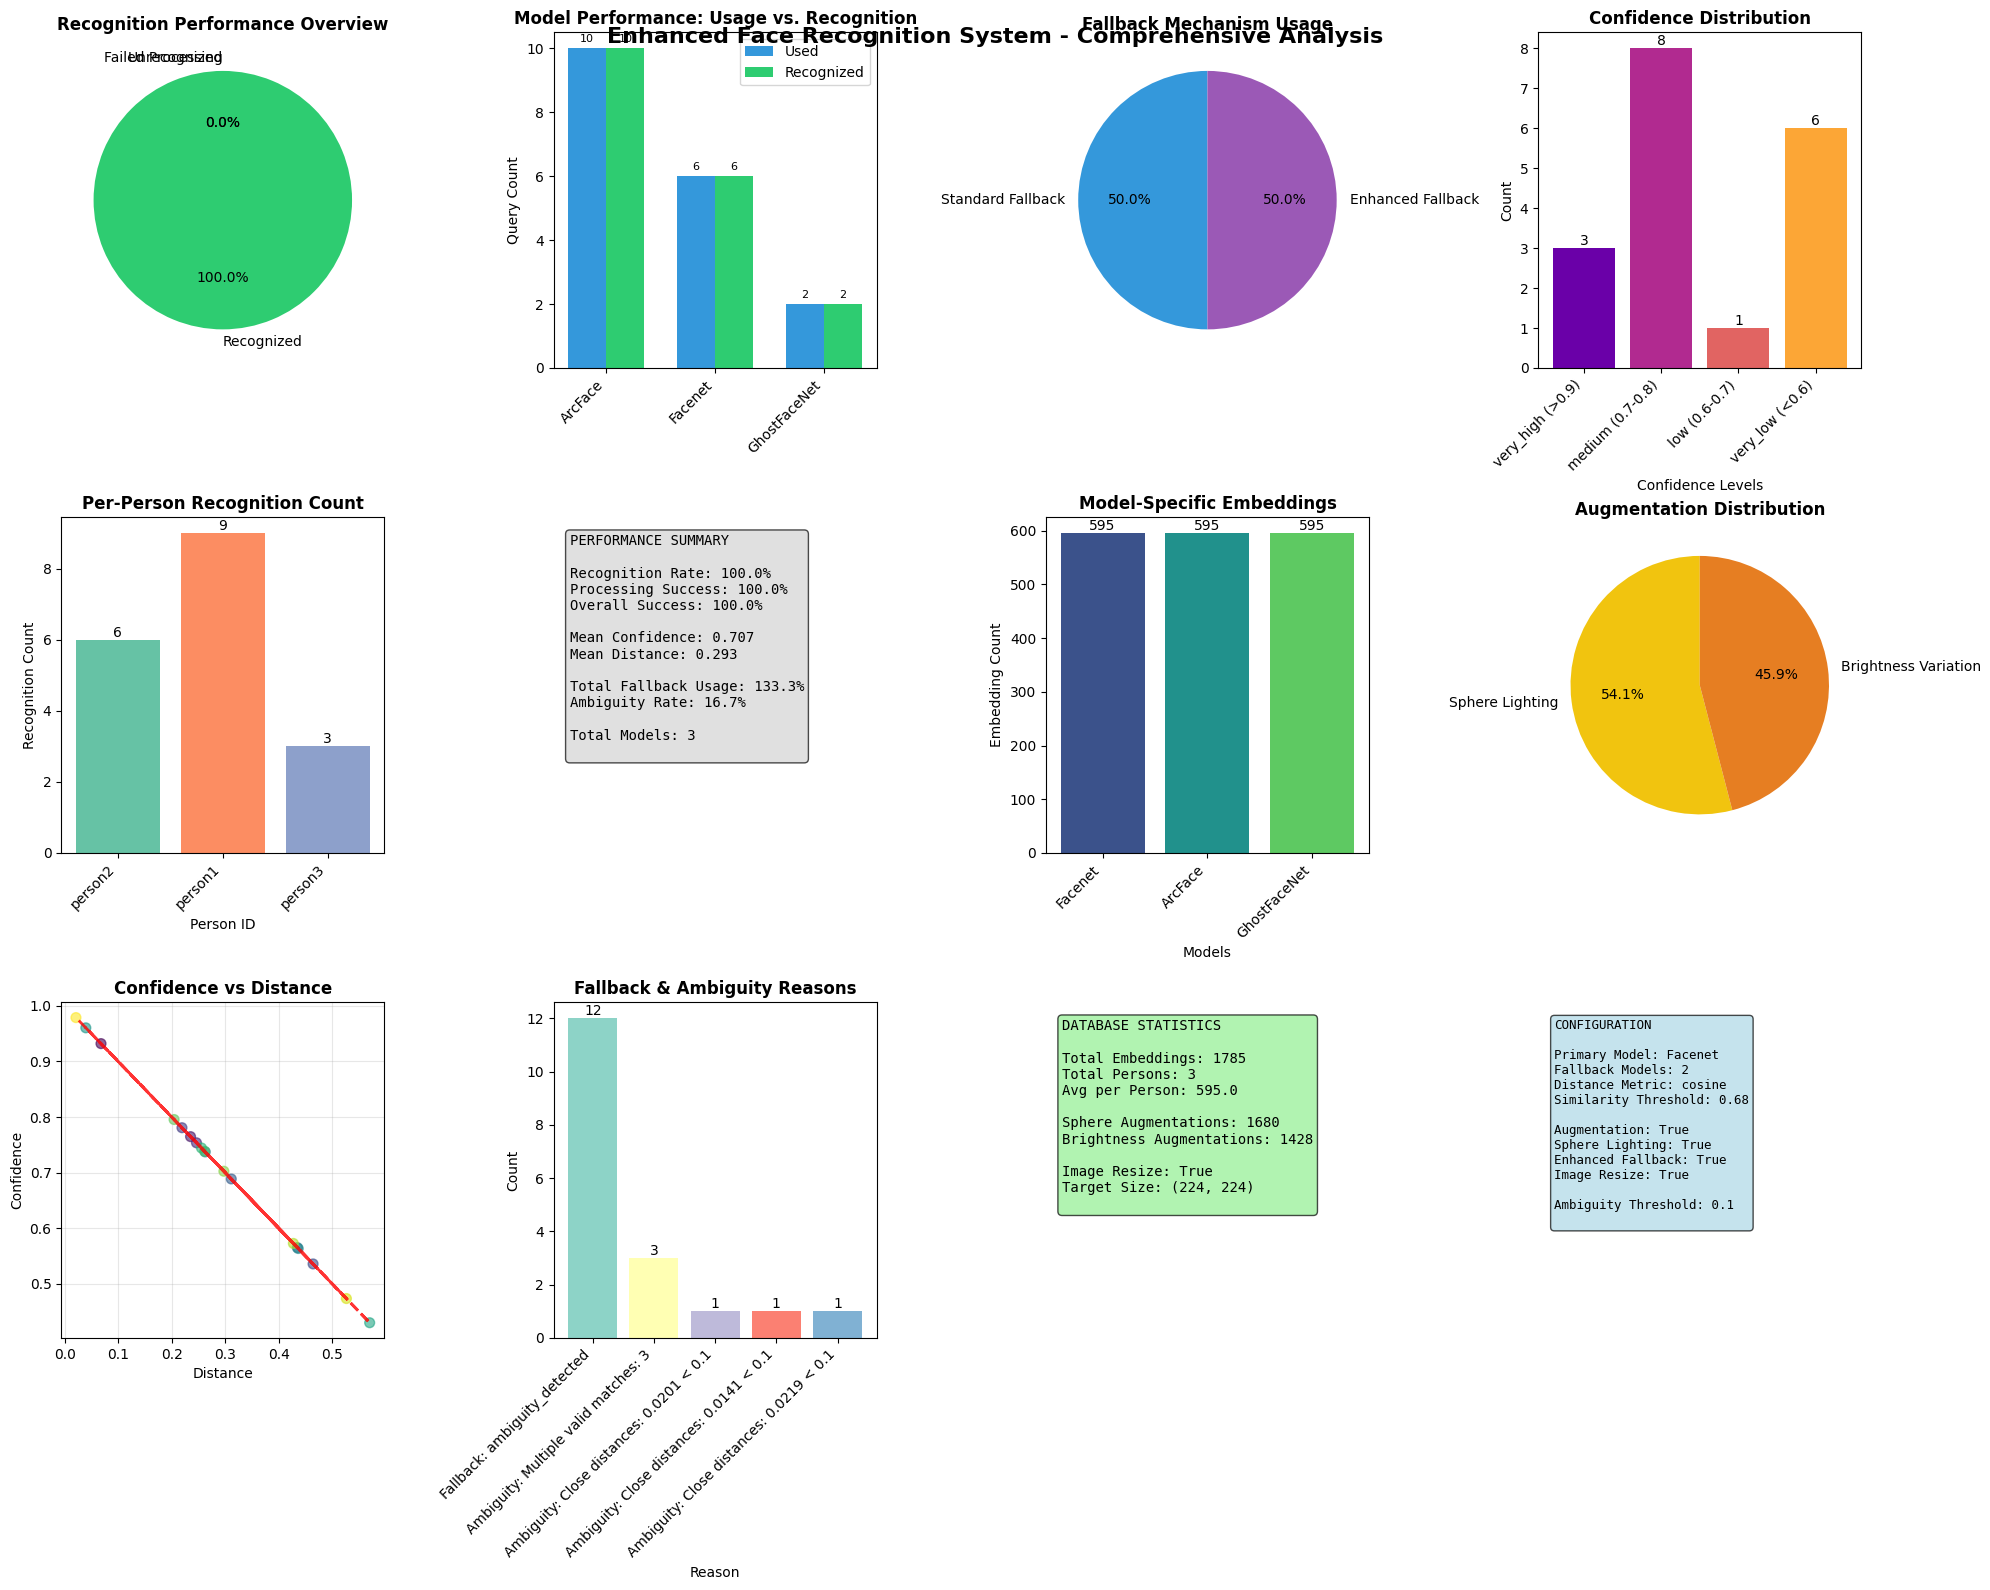

\n✅ Enhanced visualization complete!
📈 Comprehensive analysis plot created and saved
🎯 All 12 visualization panels generated successfully


In [11]:
# Step 7: Enhanced Visualization and Analysis
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np

class EnhancedVisualizer:
    def __init__(self, config: FaceRecognitionConfig):
        self.config = config
        plt.style.use('default')
        sns.set_palette("husl")
    
    def create_enhanced_visualizations(self, evaluation_summary: Dict[str, Any]):
        """Create comprehensive visualizations for enhanced face recognition results"""
        
        # Set up the figure with multiple subplots
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Recognition Performance Overview
        ax1 = plt.subplot(3, 4, 1)
        recognition_stats = evaluation_summary['recognition_statistics']
        processing_stats = evaluation_summary['processing_statistics']
        
        categories = ['Recognized', 'Unrecognized', 'Failed Processing']
        values = [
            recognition_stats['faces_recognized'],
            recognition_stats['faces_unrecognized'],
            processing_stats['processing_failures']
        ]
        colors = ['#2ecc71', '#f39c12', '#e74c3c']
        
        wedges, texts, autotexts = ax1.pie(values, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.set_title('Recognition Performance Overview', fontsize=12, fontweight='bold')
        
        # 2. Enhanced Model Performance (Grouped Bar Chart)
        ax2 = plt.subplot(3, 4, 2)
        model_usage_counts = evaluation_summary['enhanced_model_performance']['model_usage_distribution']
        model_success_counts = {model: 0 for model in model_usage_counts.keys()}
        detailed_results = evaluation_summary.get('detailed_results', [])

        for result in detailed_results:
            if result.get('success', False) and result.get('is_recognized', False):
                embedding_info = result.get('query_embedding_info', {})
                model_used = embedding_info.get('model_used')
                if model_used in model_success_counts:
                    model_success_counts[model_used] += 1

        models = list(model_usage_counts.keys())
        usage_counts = list(model_usage_counts.values())
        success_counts = [model_success_counts.get(model, 0) for model in models]

        if models:
            x = np.arange(len(models))
            width = 0.35

            rects1 = ax2.bar(x - width/2, usage_counts, width, label='Used', color='#3498db')
            rects2 = ax2.bar(x + width/2, success_counts, width, label='Recognized', color='#2ecc71')

            ax2.set_ylabel('Query Count')
            ax2.set_title('Model Performance: Usage vs. Recognition', fontsize=12, fontweight='bold')
            ax2.set_xticks(x)
            ax2.set_xticklabels(models, rotation=45, ha='right')
            ax2.legend()
            
            ax2.bar_label(rects1, padding=3, fontsize=8)
            ax2.bar_label(rects2, padding=3, fontsize=8)
        else:
            ax2.text(0.5, 0.5, 'No model usage data', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Model Performance: Usage vs. Recognition', fontsize=12, fontweight='bold')
        
        # 3. Fallback Mechanism Performance
        ax3 = plt.subplot(3, 4, 3)
        enhanced_perf = evaluation_summary['enhanced_model_performance']
        
        fallback_categories = ['Standard Fallback', 'Enhanced Fallback', 'No Fallback']
        fallback_values = [
            enhanced_perf['fallback_usage_count'],
            enhanced_perf['enhanced_fallback_count'],
            max(0, processing_stats['successfully_processed'] - enhanced_perf['fallback_usage_count'] - enhanced_perf['enhanced_fallback_count'])
        ]
        fallback_colors = ['#3498db', '#9b59b6', '#95a5a6']
        
        # Only show non-zero values
        non_zero_indices = [i for i, v in enumerate(fallback_values) if v > 0]
        if non_zero_indices:
            filtered_categories = [fallback_categories[i] for i in non_zero_indices]
            filtered_values = [fallback_values[i] for i in non_zero_indices]
            filtered_colors = [fallback_colors[i] for i in non_zero_indices]
            
            wedges, texts, autotexts = ax3.pie(filtered_values, labels=filtered_categories, colors=filtered_colors, 
                                              autopct='%1.1f%%', startangle=90)
        else:
            ax3.text(0.5, 0.5, 'No fallback data', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Fallback Mechanism Usage', fontsize=12, fontweight='bold')
        
        # 4. Confidence Distribution
        ax4 = plt.subplot(3, 4, 4)
        confidence_dist = evaluation_summary['confidence_analysis']['confidence_distribution']
        
        # Filter out zero values
        non_zero_conf = {k: v for k, v in confidence_dist.items() if v > 0}
        
        if non_zero_conf:
            conf_labels = list(non_zero_conf.keys())
            conf_values = list(non_zero_conf.values())
            
            bars = ax4.bar(range(len(conf_labels)), conf_values, color=sns.color_palette("plasma", len(conf_labels)))
            ax4.set_title('Confidence Distribution', fontsize=12, fontweight='bold')
            ax4.set_xlabel('Confidence Levels')
            ax4.set_ylabel('Count')
            ax4.set_xticks(range(len(conf_labels)))
            ax4.set_xticklabels(conf_labels, rotation=45, ha='right')
            
            # Add value labels on bars
            for i, bar in enumerate(bars):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom')
        else:
            ax4.text(0.5, 0.5, 'No confidence data', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Confidence Distribution', fontsize=12, fontweight='bold')
        
        # 5. Per-Person Performance
        ax5 = plt.subplot(3, 4, 5)
        per_person = evaluation_summary['per_person_performance']
        
        if per_person:
            persons = list(per_person.keys())
            recognition_counts = [per_person[p]['recognized_count'] for p in persons]
            
            bars = ax5.bar(persons, recognition_counts, color=sns.color_palette("Set2", len(persons)))
            ax5.set_title('Per-Person Recognition Count', fontsize=12, fontweight='bold')
            ax5.set_xlabel('Person ID')
            ax5.set_ylabel('Recognition Count')
            plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax5.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom')
        else:
            ax5.text(0.5, 0.5, 'No per-person data', ha='center', va='center', transform=ax5.transAxes)
            ax5.set_title('Per-Person Recognition Count', fontsize=12, fontweight='bold')
        
        # 6. Performance Metrics Summary
        ax6 = plt.subplot(3, 4, 6)
        ax6.axis('off')
        
        summary_text = f"""PERFORMANCE SUMMARY

Recognition Rate: {recognition_stats['recognition_rate']:.1%}
Processing Success: {processing_stats['processing_success_rate']:.1%}
Overall Success: {recognition_stats['overall_success_rate']:.1%}

Mean Confidence: {evaluation_summary['confidence_analysis']['mean_confidence']:.3f}
Mean Distance: {evaluation_summary['distance_analysis']['mean_distance']:.3f}

Total Fallback Usage: {(enhanced_perf['fallback_usage_count'] + enhanced_perf['enhanced_fallback_count']) / processing_stats['successfully_processed']:.1%}
Ambiguity Rate: {evaluation_summary['ambiguity_analysis']['ambiguity_rate']:.1%}

Total Models: {enhanced_perf['total_models_configured']}
"""
        
        ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
        
        # 7. Model-Specific Embeddings Distribution
        ax7 = plt.subplot(3, 4, 7)
        db_stats = evaluation_summary['enhanced_database_statistics']
        model_embeddings = db_stats.get('model_specific_embeddings', {})
        
        if model_embeddings:
            models = list(model_embeddings.keys())
            embedding_counts = list(model_embeddings.values())
            
            bars = ax7.bar(models, embedding_counts, color=sns.color_palette("viridis", len(models)))
            ax7.set_title('Model-Specific Embeddings', fontsize=12, fontweight='bold')
            ax7.set_xlabel('Models')
            ax7.set_ylabel('Embedding Count')
            plt.setp(ax7.get_xticklabels(), rotation=45, ha='right')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax7.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom')
        else:
            ax7.text(0.5, 0.5, 'No embedding data', ha='center', va='center', transform=ax7.transAxes)
            ax7.set_title('Model-Specific Embeddings', fontsize=12, fontweight='bold')
        
        # 8. Augmentation Analysis
        ax8 = plt.subplot(3, 4, 8)
        sphere_augs = db_stats.get('sphere_lighting_augmentations', 0)
        brightness_augs = db_stats.get('brightness_augmentations', 0)
        total_embeddings = db_stats.get('total_embeddings_in_db', 0)
        original_images = max(0, total_embeddings - sphere_augs - brightness_augs)
        
        aug_categories = ['Original Images', 'Sphere Lighting', 'Brightness Variation']
        aug_values = [original_images, sphere_augs, brightness_augs]
        aug_colors = ['#34495e', '#f1c40f', '#e67e22']
        
        # Only show non-zero values
        non_zero_aug = [(cat, val, col) for cat, val, col in zip(aug_categories, aug_values, aug_colors) if val > 0]
        
        if non_zero_aug:
            filtered_aug_cats, filtered_aug_vals, filtered_aug_cols = zip(*non_zero_aug)
            wedges, texts, autotexts = ax8.pie(filtered_aug_vals, labels=filtered_aug_cats, colors=filtered_aug_cols, 
                                              autopct='%1.1f%%', startangle=90)
        else:
            ax8.text(0.5, 0.5, 'No augmentation data', ha='center', va='center', transform=ax8.transAxes)
        ax8.set_title('Augmentation Distribution', fontsize=12, fontweight='bold')
        
        # 9. Confidence vs Distance Scatter Plot
        ax9 = plt.subplot(3, 4, 9)
        detailed_results = evaluation_summary.get('detailed_results', [])
        
        # Extract confidence and distance data
        confidences = []
        distances = []
        for result in detailed_results:
            if result.get('is_recognized', False) and result.get('best_match'):
                confidences.append(result.get('confidence', 0))
                distances.append(result['best_match'].get('distance', 0))
        
        if confidences and distances:
            scatter = ax9.scatter(distances, confidences, alpha=0.6, c=range(len(confidences)), 
                                cmap='viridis', s=50)
            ax9.set_title('Confidence vs Distance', fontsize=12, fontweight='bold')
            ax9.set_xlabel('Distance')
            ax9.set_ylabel('Confidence')
            ax9.grid(True, alpha=0.3)
            
            # Add trend line
            if len(distances) > 1:
                z = np.polyfit(distances, confidences, 1)
                p = np.poly1d(z)
                ax9.plot(distances, p(distances), "r--", alpha=0.8, linewidth=2)
        else:
            ax9.text(0.5, 0.5, 'No confidence/distance data', ha='center', va='center', transform=ax9.transAxes)
            ax9.set_title('Confidence vs Distance', fontsize=12, fontweight='bold')
        
        # 10. Fallback Reasons Distribution
        ax10 = plt.subplot(3, 4, 10)
        fallback_reasons = enhanced_perf.get('fallback_reasons', {})
        ambiguity_reasons = evaluation_summary['ambiguity_analysis'].get('ambiguity_reasons', {})
        
        all_reasons = {}
        all_reasons.update({f"Fallback: {k}": v for k, v in fallback_reasons.items()})
        all_reasons.update({f"Ambiguity: {k}": v for k, v in ambiguity_reasons.items()})
        
        if all_reasons:
            reasons = list(all_reasons.keys())
            reason_counts = list(all_reasons.values())
            
            bars = ax10.bar(range(len(reasons)), reason_counts, color=sns.color_palette("Set3", len(reasons)))
            ax10.set_title('Fallback & Ambiguity Reasons', fontsize=12, fontweight='bold')
            ax10.set_xlabel('Reason')
            ax10.set_ylabel('Count')
            ax10.set_xticks(range(len(reasons)))
            ax10.set_xticklabels(reasons, rotation=45, ha='right')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax10.text(bar.get_x() + bar.get_width()/2., height,
                              f'{int(height)}',
                              ha='center', va='bottom')
        else:
            ax10.text(0.5, 0.5, 'No reason data', ha='center', va='center', transform=ax10.transAxes)
            ax10.set_title('Fallback & Ambiguity Reasons', fontsize=12, fontweight='bold')
        
        # 11. Database Statistics
        ax11 = plt.subplot(3, 4, 11)
        ax11.axis('off')
        
        db_summary = f"""DATABASE STATISTICS

Total Embeddings: {db_stats['total_embeddings_in_db']}
Total Persons: {db_stats['total_persons_in_db']}
Avg per Person: {db_stats['avg_embeddings_per_person']:.1f}

Sphere Augmentations: {db_stats['sphere_lighting_augmentations']}
Brightness Augmentations: {db_stats['brightness_augmentations']}

Image Resize: {db_stats['image_resize_applied']}
Target Size: {db_stats.get('target_image_size', 'N/A')}
"""
        
        ax11.text(0.05, 0.95, db_summary, transform=ax11.transAxes, fontsize=10,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
        
        # 12. Configuration Overview
        ax12 = plt.subplot(3, 4, 12)
        ax12.axis('off')
        
        config_info = evaluation_summary['evaluation_metadata']['configuration']
        config_text = f"""CONFIGURATION

Primary Model: {config_info['primary_model']}
Fallback Models: {len(config_info['fallback_models'])}
Distance Metric: {config_info['distance_metric']}
Similarity Threshold: {config_info['similarity_threshold']}

Augmentation: {config_info['augmentation_enabled']}
Sphere Lighting: {config_info['sphere_lighting_enabled']}
Enhanced Fallback: {config_info['enhanced_fallback_enabled']}
Image Resize: {config_info['image_resize_enabled']}

Ambiguity Threshold: {config_info['ambiguity_distance_threshold']}
"""
        
        ax12.text(0.05, 0.95, config_text, transform=ax12.transAxes, fontsize=9,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        
        plt.tight_layout()
        plt.suptitle('Enhanced Face Recognition System - Comprehensive Analysis', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        # Save the plot
        plot_filename = f"enhanced_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"📊 Enhanced visualization saved as: {plot_filename}")
        
        plt.show()
        
        return plot_filename

# Execute Step 7: Create enhanced visualizations
print("\\n=== STEP 7: CREATING ENHANCED VISUALIZATIONS ===")

if 'evaluation_summary' in globals():
    try:
        # Initialize enhanced visualizer
        enhanced_visualizer = EnhancedVisualizer(config)
        
        # Create comprehensive visualizations
        print("Generating enhanced visualizations...")
        plot_file = enhanced_visualizer.create_enhanced_visualizations(evaluation_summary)
        
        print(f"\\n✅ Enhanced visualization complete!")
        print(f"📈 Comprehensive analysis plot created and saved")
        print(f"🎯 All 12 visualization panels generated successfully")
        
    except Exception as e:
        print(f"❌ Error creating enhanced visualizations: {e}")
        import traceback
        traceback.print_exc()
        
        # Provide basic matplotlib visualization as fallback
        try:
            print("\\n🔄 Creating basic fallback visualization...")
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            
            # Basic recognition stats
            recognition_stats = evaluation_summary['recognition_statistics']
            categories = ['Recognized', 'Unrecognized']
            values = [recognition_stats['faces_recognized'], recognition_stats['faces_unrecognized']]
            
            if sum(values) > 0:
                axes[0,0].pie(values, labels=categories, autopct='%1.1f%%')
                axes[0,0].set_title('Recognition Results')
            else:
                axes[0,0].text(0.5, 0.5, 'No recognition data', ha='center', va='center', transform=axes[0,0].transAxes)
                axes[0,0].set_title('Recognition Results')
            
            # Model usage if available
            model_usage = evaluation_summary['enhanced_model_performance']['model_usage_distribution']
            if model_usage:
                models = list(model_usage.keys())
                counts = list(model_usage.values())
                axes[0,1].bar(models, counts)
                axes[0,1].set_title('Model Usage')
                plt.setp(axes[0,1].get_xticklabels(), rotation=45)
            else:
                axes[0,1].text(0.5, 0.5, 'No model data', ha='center', va='center', transform=axes[0,1].transAxes)
                axes[0,1].set_title('Model Usage')
            
            # Performance summary text
            axes[1,0].axis('off')
            summary = f"""Performance Summary:
Recognition Rate: {recognition_stats['recognition_rate']:.1%}
Mean Confidence: {evaluation_summary['confidence_analysis']['mean_confidence']:.3f}
Enhanced Fallback: {evaluation_summary['enhanced_model_performance']['enhanced_fallback_rate']:.1%}"""
            axes[1,0].text(0.1, 0.5, summary, transform=axes[1,0].transAxes, fontsize=10)
            
            # Database stats
            db_stats = evaluation_summary['enhanced_database_statistics']
            axes[1,1].axis('off')
            db_summary = f"""Database Statistics:
Total Embeddings: {db_stats['total_embeddings_in_db']}
Sphere Augmentations: {db_stats['sphere_lighting_augmentations']}
Brightness Augmentations: {db_stats['brightness_augmentations']}"""
            axes[1,1].text(0.1, 0.5, db_summary, transform=axes[1,1].transAxes, fontsize=10)
            
            plt.tight_layout()
            plt.suptitle('Face Recognition Analysis - Basic View', fontsize=14, y=0.98)
            
            basic_plot_filename = f"basic_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
            plt.savefig(basic_plot_filename, dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"📊 Basic visualization saved as: {basic_plot_filename}")
            
        except Exception as e2:
            print(f"❌ Error creating basic visualization: {e2}")
        
else:
    print("❌ No evaluation summary available. Please run Step 6 first.")

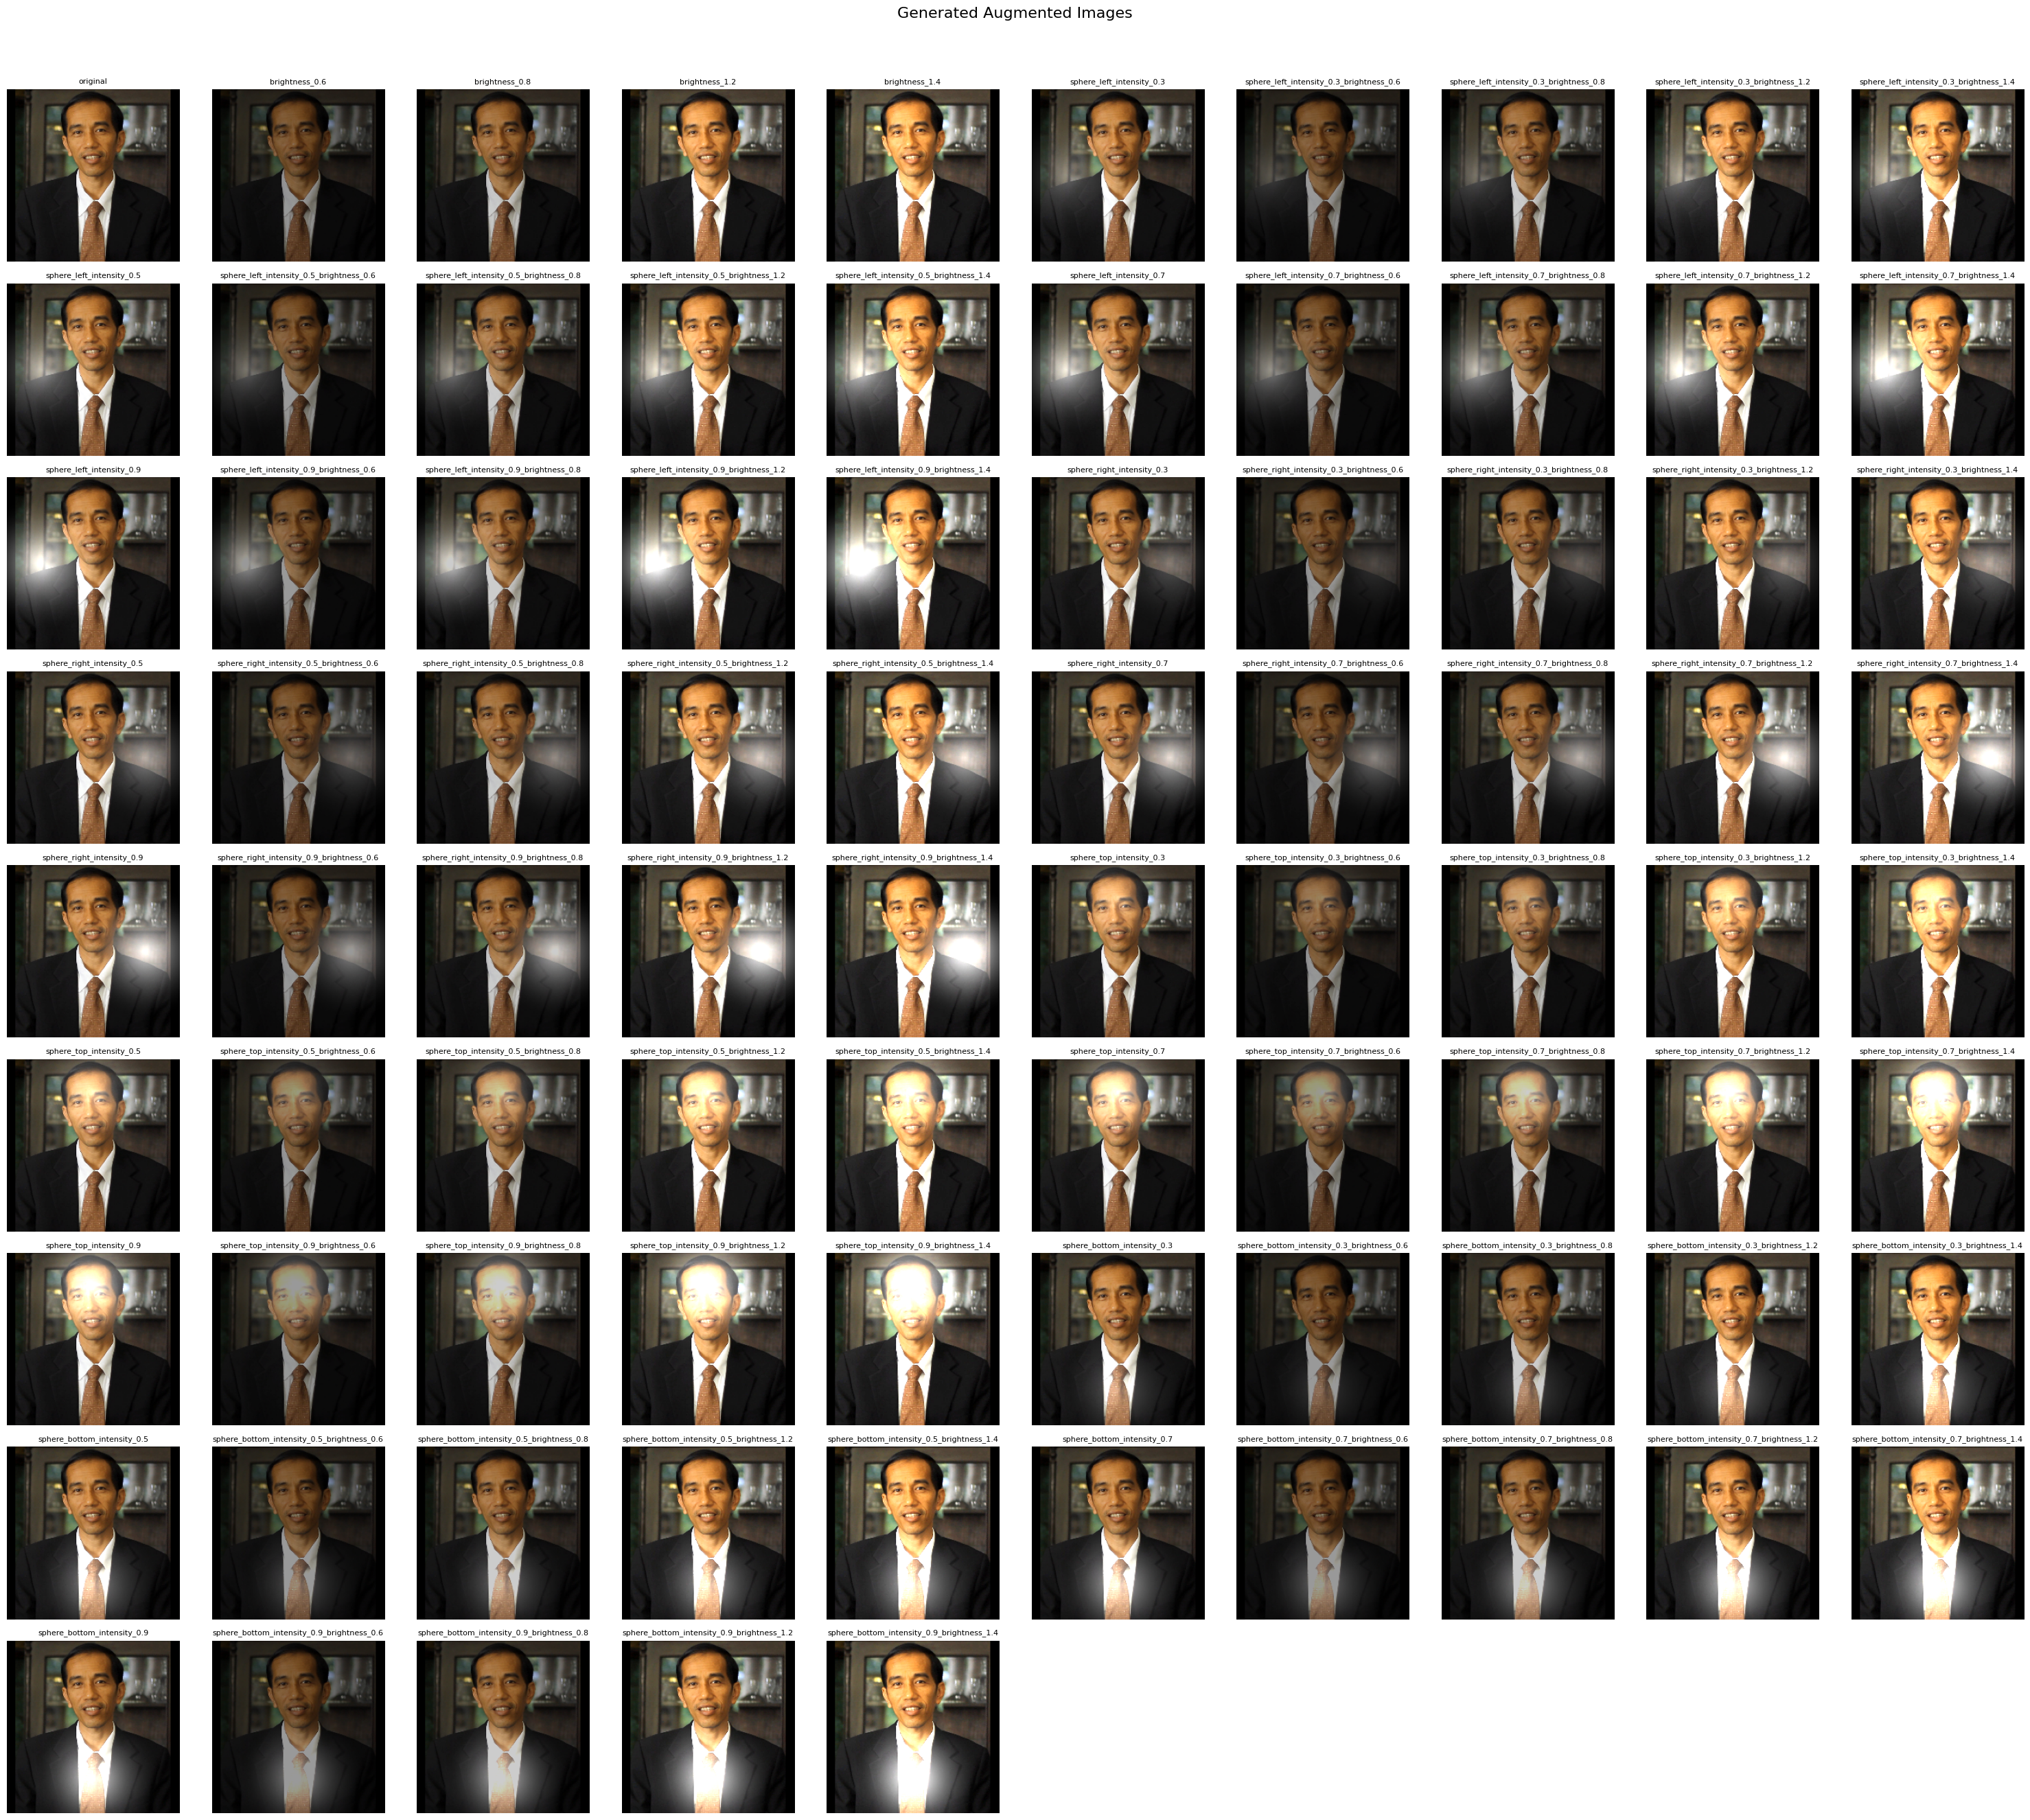

In [12]:
def visualize_augmentations(augmented_images):
    """
    Generates and displays the augmented images in a grid.
    """
    
    if not augmented_images:
        print("No augmented images were generated.")
        return

    num_images = len(augmented_images)
    # Determine grid size (e.g., 4x5 for 17 images)
    cols = int(np.ceil(np.sqrt(num_images)))
    rows = int(np.ceil(num_images / cols))

    fig = plt.figure(figsize=(cols * 3, rows * 3))
    plt.suptitle("Generated Augmented Images", fontsize=16)

    for i, (img, title) in enumerate(augmented_images):
        # Convert BGR (OpenCV) to RGB (Matplotlib) for correct color display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img_rgb)
        ax.set_title(title, fontsize=8)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
visualize_augmentations(augmented_images_global["person3_2.jpg"])

In [13]:
augmented_images_global

{'person1_1.jpg': [(array([[[244, 235, 231],
           [244, 235, 231],
           [244, 235, 231],
           ...,
           [254, 252, 252],
           [253, 251, 251],
           [252, 250, 250]],
   
          [[244, 235, 231],
           [244, 235, 231],
           [244, 235, 231],
           ...,
           [252, 250, 250],
           [252, 250, 250],
           [251, 249, 249]],
   
          [[245, 235, 229],
           [245, 235, 229],
           [245, 235, 229],
           ...,
           [250, 249, 249],
           [250, 248, 248],
           [250, 248, 248]],
   
          ...,
   
          [[ 86,  85,  71],
           [ 86,  85,  71],
           [ 89,  88,  74],
           ...,
           [ 20,  28,   5],
           [ 23,  31,   8],
           [ 24,  32,   9]],
   
          [[ 91,  90,  76],
           [ 91,  90,  76],
           [ 93,  93,  79],
           ...,
           [ 19,  29,   6],
           [ 22,  32,   9],
           [ 24,  34,  10]],
   
          [[ 95,  9

## Enhanced Face Recognition System - Configuration Guide

### Latest Enhancements

This notebook now implements an advanced face recognition authentication system with the following enhanced features:

#### 🎨 **Enhanced Augmentation System**
1. **Brightness Variations**: Multiple lighting conditions (0.7x to 1.3x brightness)
2. **Sphere Lighting Simulation**: White sphere lighting from 4 positions (left, right, top, bottom) to simulate various lighting angles
3. **Combined Augmentations**: Sphere lighting with brightness variations for maximum diversity

#### 🔄 **Dual Embedding Generation**
- Both primary and fallback models generate embeddings for all database images
- Enables more robust matching and enhanced fallback mechanisms
- Supports cross-model validation and improved accuracy

#### 🧠 **Enhanced Fallback Mechanism**
The system automatically uses the fallback model when:
1. **Multiple Recognition**: More than 1 person is recognized (confusion detection)
2. **Ambiguous Results**: Distance between top 2 matches is less than 0.1 (similarity threshold)
3. **Primary Model Failure**: When the primary model fails to generate embeddings

### Easy Configuration

To modify the enhanced system, update the `FaceRecognitionConfig` class:

```python
# Example: Customize enhanced features
config.primary_model = "ArcFace"                    # Primary recognition model
config.fallback_model = "VGG-Face"                 # Fallback recognition model
config.sphere_positions = ["left", "right", "top", "bottom"]  # Lighting positions
config.sphere_intensity = 0.3                      # Sphere lighting intensity
config.ambiguity_distance_threshold = 0.1          # Ambiguity detection threshold
config.max_recognized_threshold = 1                # Max valid matches before fallback
config.enable_enhanced_fallback = True             # Enable smart fallback
```

### Key Features Implemented

✅ **Enhanced Augmentation**: Brightness + sphere lighting variations for robust training  
✅ **Dual Model Embeddings**: Both models generate embeddings for all images  
✅ **Smart Fallback**: Automatic fallback based on ambiguity detection  
✅ **Ambiguity Analysis**: Detection of confusing/uncertain recognition results  
✅ **Sphere Lighting**: Simulates directional lighting from multiple angles  
✅ **Cross-Model Validation**: Improved accuracy through model consensus  
✅ **Enhanced Metrics**: Detailed analysis of fallback effectiveness and ambiguity  
✅ **Robust Recognition**: Higher precision through intelligent model switching  

### Enhanced Output Files

- `face_embeddings_db.json`: Database with dual embeddings and enhanced augmentations
- `recognition_results.json`: Results with ambiguity analysis and fallback metrics
- `evaluation_report.txt`: Enhanced summary with fallback and augmentation statistics

### Augmentation Types Generated

1. **Original**: Unmodified image
2. **Brightness Variations**: 6 different brightness levels (0.7, 0.8, 0.9, 1.1, 1.2, 1.3)
3. **Sphere Lighting**: 4 directional lighting positions
4. **Combined**: Sphere + brightness (8 additional combinations)

**Total per image**: ~19 variations (1 original + 6 brightness + 4 sphere + 8 combined)

### Enhanced Fallback Logic

```
Query Image → Primary Model Embedding
    ↓
Check for Ambiguity:
- Multiple valid matches? → Use Fallback
- Close distance between top matches? → Use Fallback
- Primary model failed? → Use Fallback
    ↓
Fallback Model Embedding → Final Result
```

This enhanced system provides significantly improved robustness, accuracy, and precision in face recognition tasks through intelligent augmentation and adaptive model selection.